In [390]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost
import pandas_profiling as pf
import warnings
warnings.filterwarnings('ignore')

In [391]:
df=pd.read_csv('OnlineNewsPopularity.csv')

In [ ]:
import dill
dill.dump_session('binary.db')

In [393]:
#Removing spaces in column names
df.columns=[i.strip() for i in df.columns]

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
url                              39644 non-null object
timedelta                        39644 non-null float64
n_tokens_title                   39644 non-null float64
n_tokens_content                 39644 non-null float64
n_unique_tokens                  39644 non-null float64
n_non_stop_words                 39644 non-null float64
n_non_stop_unique_tokens         39644 non-null float64
num_hrefs                        39644 non-null float64
num_self_hrefs                   39644 non-null float64
num_imgs                         39644 non-null float64
num_videos                       39644 non-null float64
average_token_length             39644 non-null float64
num_keywords                     39644 non-null float64
data_channel_is_lifestyle        39644 non-null float64
data_channel_is_entertainment    39644 non-null float64
data_channel_is_bus              39644 non-null floa

In [306]:
df['shares'].median()

1400.0

In [394]:
#Converting target variable from continuous to categorical by setting threshold as median 
df['class']=[0 if i<=1400 else 1 for i in df.shares ]

## Bivariate Analysis

## Words

<ol>
<li>n_tokens_title: Number of words in the title
<li>n_tokens_content: Number of words in the content
<li>n_unique_tokens: Rate of unique words in the content
<li>n_non_stop_words: Rate of non-stop words in the content
<li>n_non_stop_unique_tokens: Rate of unique non-stop words in the content
<li>average_token_length: Average length of the words in the content
</ol>

In [395]:
words=['n_tokens_title','n_tokens_content','average_token_length','n_non_stop_words','n_unique_tokens','n_non_stop_unique_tokens']

In [16]:
df[words].head()

n_tokens_title  n_tokens_content  average_token_length  n_non_stop_words  \
0            12.0             219.0              4.680365               1.0   
1             9.0             255.0              4.913725               1.0   
2             9.0             211.0              4.393365               1.0   
3             9.0             531.0              4.404896               1.0   
4            13.0            1072.0              4.682836               1.0   

   n_unique_tokens  n_non_stop_unique_tokens  
0         0.663594                  0.815385  
1         0.604743                  0.791946  
2         0.575130                  0.663866  
3         0.503788                  0.665635  
4         0.415646                  0.540890

In [28]:
#Outlier
df[df.n_non_stop_words==max(df.n_non_stop_words)]

url  timedelta  \
31037  http://mashable.com/2014/08/18/ukraine-civilia...      142.0   

       n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
31037             9.0            1570.0            701.0            1042.0   

       n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  ...  \
31037                     650.0       11.0            10.0      51.0  ...   

       max_positive_polarity  avg_negative_polarity  min_negative_polarity  \
31037                    0.0                    0.0                    0.0   

       max_negative_polarity  title_subjectivity  title_sentiment_polarity  \
31037                    0.0                 0.0                       0.0   

       abs_title_subjectivity  abs_title_sentiment_polarity  shares  class  
31037                     0.0                           0.0    5900      1  

[1 rows x 62 columns]

In [327]:
#Dropping the outlier
df=df.drop(df.index[31037])

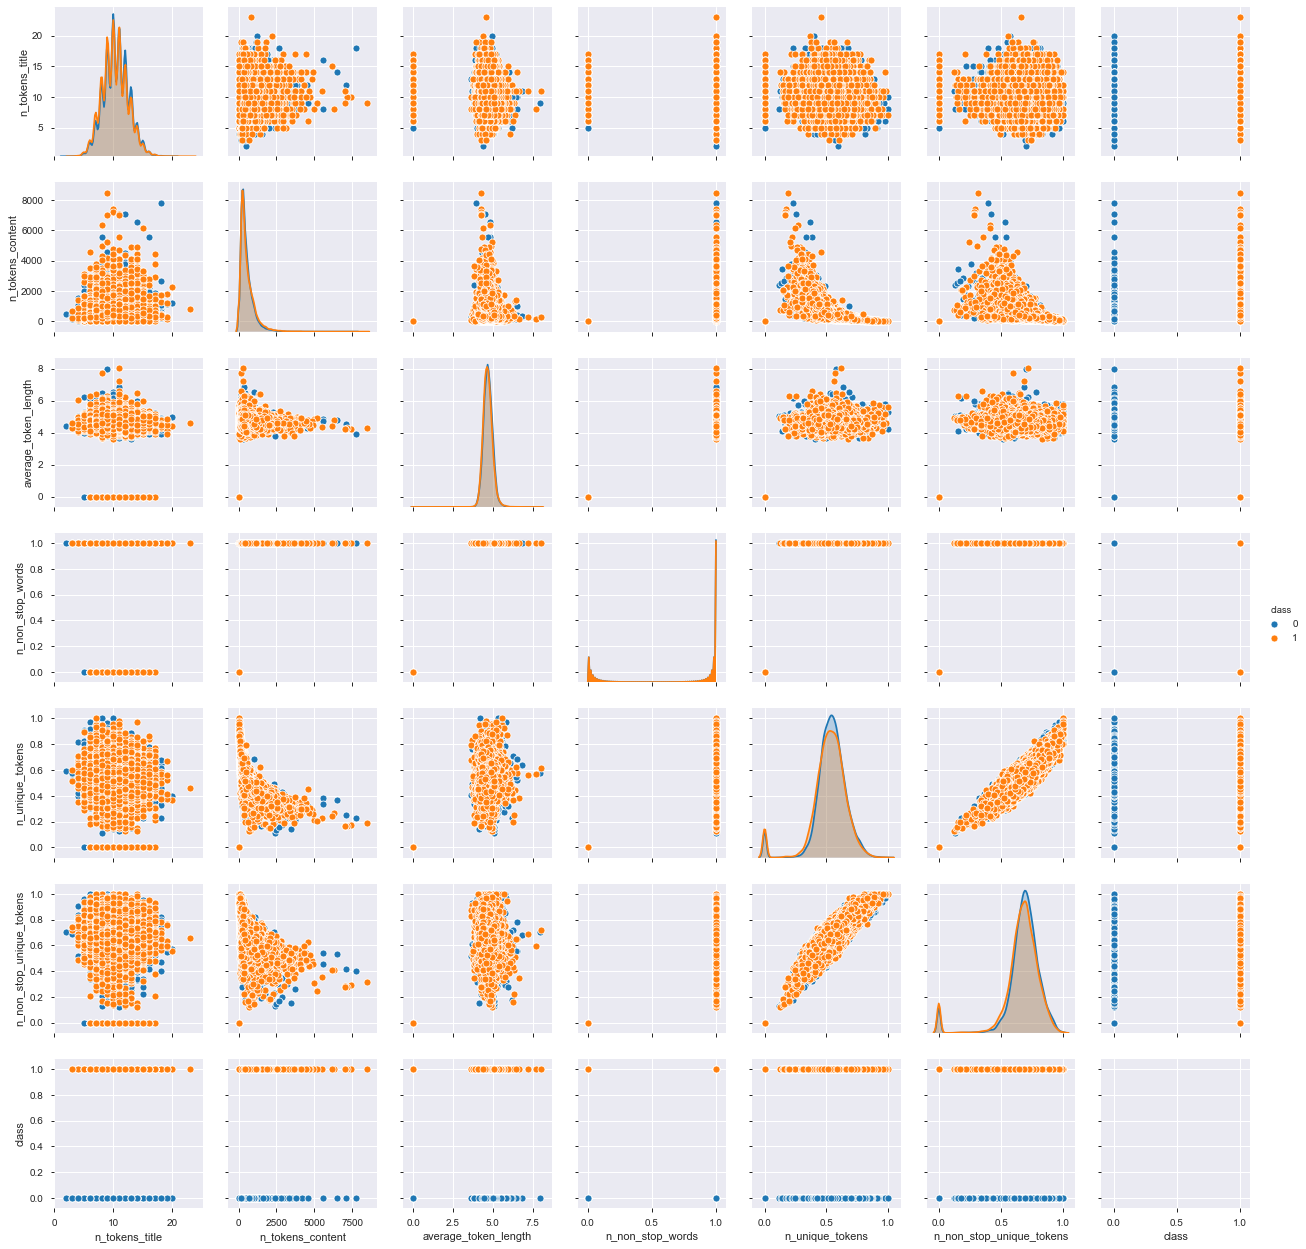

In [30]:
sns.pairplot(df,vars=df[words+['class']],diag_kind='kde',hue='class')
plt.show()

In [ ]:
# As we can see there is no distinct of classes for any  of the features ie the distribution of fearure is same or 
#overlapping for class 0 and 1, none of the columns are significant for classification

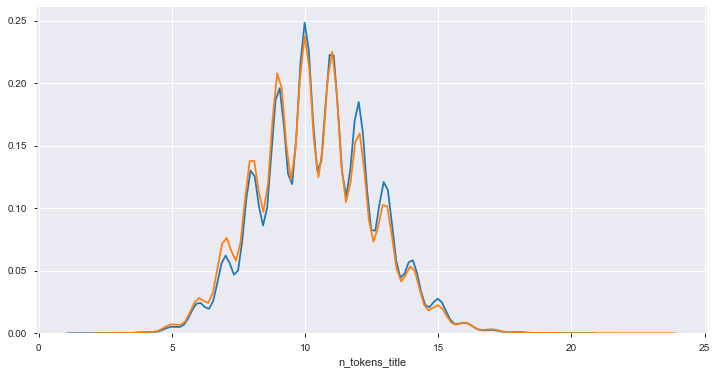

In [403]:
plt.figure(figsize=(12,6))
sns.distplot(df[df['class']==0]['n_tokens_title'],hist=False)
sns.distplot(df[df['class']==1]['n_tokens_title'],hist=False)
plt.show()

In [404]:
stats.levene(df[df['class']==0]['n_tokens_title'],df[df['class']==1]['n_tokens_title'])

LeveneResult(statistic=0.0032386850328870085, pvalue=0.9546176165708481)

In [405]:
stats.kruskal(df[df['class']==0]['n_tokens_title'],df[df['class']==1]['n_tokens_title'])

KruskalResult(statistic=80.67421508614356, pvalue=2.661727476995133e-19)

In [409]:
for i in words:
    print(f'kruskal for {i} ')
    df_1=pd.DataFrame({'output':0,i:df[df['class']==0][i]})
    df_2=pd.DataFrame({'output':1,i:df[df['class']==1][i]})
    print(stats.kruskal(df_1[i],df_2[i]))

kruskal for n_tokens_title 
KruskalResult(statistic=80.67421508614356, pvalue=2.661727476995133e-19)
kruskal for n_tokens_content 
KruskalResult(statistic=7.893788313845659, pvalue=0.004960485763101126)
kruskal for average_token_length 
KruskalResult(statistic=90.50512551570827, pvalue=1.844983376723451e-21)
kruskal for n_non_stop_words 
KruskalResult(statistic=7.19090187770907, pvalue=0.007327414302410898)
kruskal for n_unique_tokens 
KruskalResult(statistic=81.37592278551605, pvalue=1.86617728351762e-19)
kruskal for n_non_stop_unique_tokens 
KruskalResult(statistic=169.13110574176142, pvalue=1.1453664079849295e-38)


## Links and digital media
<ol>
<li>num_hrefs: Number of links
<li>num_self_hrefs: Number of links to other articles published by Mashable
<li>num_imgs: Number of images
<li>num_videos: Number of videos
</ol>

In [35]:
link_med= ['num_hrefs','num_self_hrefs','num_imgs','num_videos']

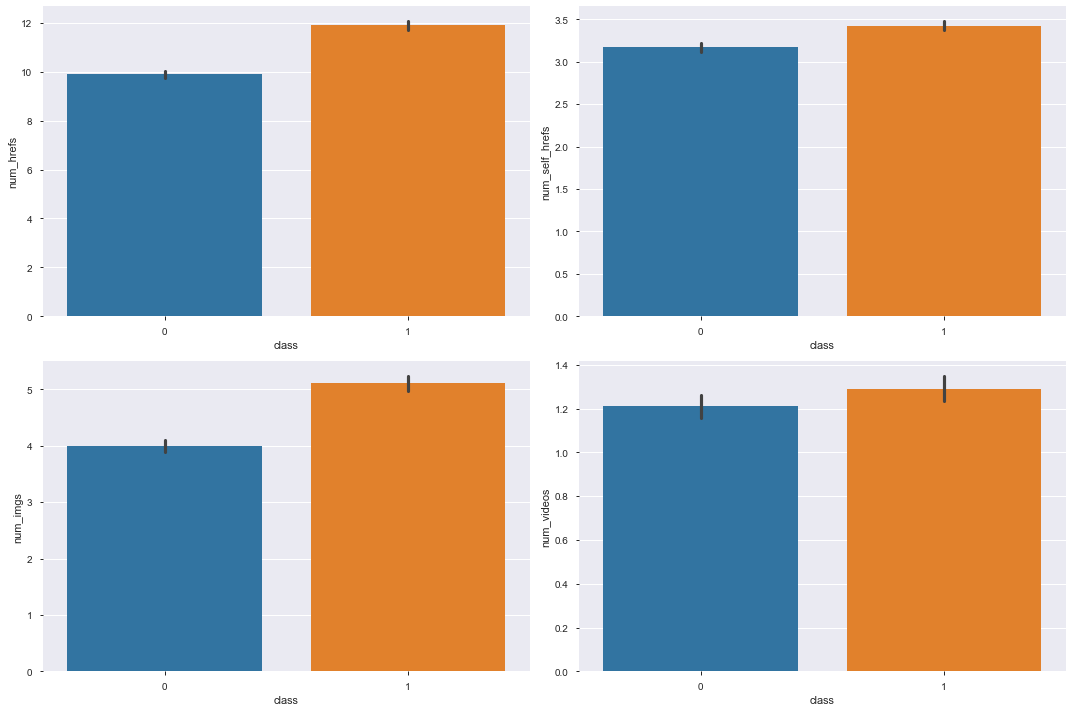

In [87]:
cnt=1
plt.figure(figsize=(15,10))
for i in link_med:
    plt.subplot(2,2,cnt)
    cnt+=1
    sns.barplot(df['class'],df[i])
plt.tight_layout()
plt.show()

In [ ]:
## Mean of all links features is similar irrespective of  class 0  and 1 except for images and links

In [328]:
# Merging the weekdays columns channels as one single column
publishdayMerge=df[['weekday_is_monday','weekday_is_tuesday','weekday_is_wednesday', 
                      'weekday_is_thursday', 'weekday_is_friday','weekday_is_saturday' ,'weekday_is_sunday' ]]
temp_arr=[]
for r in list(range(publishdayMerge.shape[0])):
    for c in list(range(publishdayMerge.shape[1])):
        if ((c==0) and (publishdayMerge.iloc[r,c])==1):
            temp_arr.append('Monday')
        elif ((c==1) and (publishdayMerge.iloc[r,c])==1):
            temp_arr.append('Tuesday')
        elif ((c==2) and (publishdayMerge.iloc[r,c])==1):
            temp_arr.append('Wednesday')
        elif ((c==3) and (publishdayMerge.iloc[r,c])==1):
            temp_arr.append('Thursday')
        elif ((c==4) and (publishdayMerge.iloc[r,c])==1):
            temp_arr.append('Friday')
        elif ((c==5) and (publishdayMerge.iloc[r,c])==1):
            temp_arr.append('Saturday') 
        elif ((c==6) and (publishdayMerge.iloc[r,c])==1):
            temp_arr.append('Sunday')
            
# Merging the data channels as one single column
DataChannelMerge=df[['data_channel_is_lifestyle','data_channel_is_entertainment' ,'data_channel_is_bus',
                        'data_channel_is_socmed' ,'data_channel_is_tech','data_channel_is_world' ]]
#logic to merge data channel
DataChannel_arr=[]
for r in list(range(DataChannelMerge.shape[0])):
    if (((DataChannelMerge.iloc[r,0])==0) and ((DataChannelMerge.iloc[r,1])==0) and ((DataChannelMerge.iloc[r,2])==0) and ((DataChannelMerge.iloc[r,3])==0) and ((DataChannelMerge.iloc[r,4])==0) and ((DataChannelMerge.iloc[r,5])==0)):
        DataChannel_arr.append('Others')# if all columns have 0 value so put in Others category
    for c in list(range(DataChannelMerge.shape[1])):
        if ((c==0) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append('Lifestyle')
        elif ((c==1) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append('Entertainment')
        elif ((c==2) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append('Business')
        elif ((c==3) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append('Social Media')
        elif ((c==4) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append('Tech')
        elif ((c==5) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append('World')

In [329]:
# merge the the new data into the dataframe
df.insert(loc=11, column='weekdays', value=temp_arr)
df.insert(loc=12, column='data_channel', value=DataChannel_arr)


print(df.shape)

(39643, 64)


## Publication Time

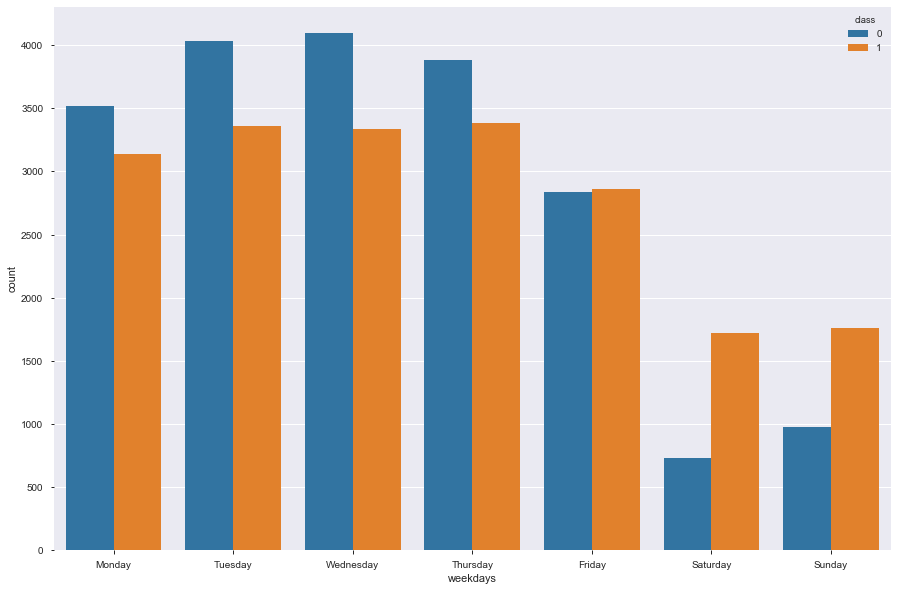

In [55]:
plt.figure(figsize=(15,10))
sns.countplot(df.weekdays,hue=df['class'])
plt.show()


In [ ]:
# Here we can see articles published on saturday or sunday have higher chance of being popular
# and if article is published on weekday , they have low prob of getting popular

## Type of News

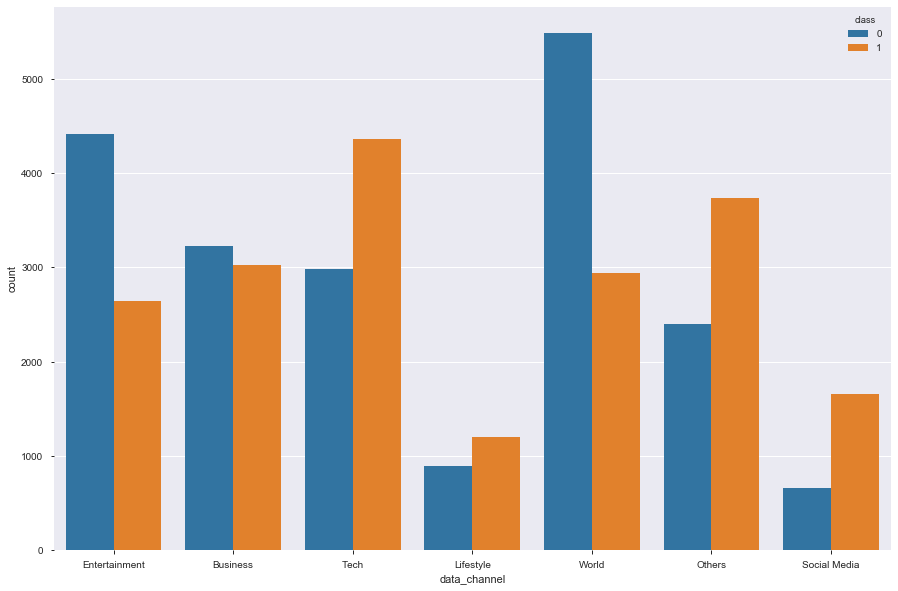

In [58]:
plt.figure(figsize=(15,10))
sns.countplot(df.data_channel,hue=df['class'])
plt.show()
#max mean of shares is from others category

In [ ]:
## Tech,social media ,lifestyle and others have high chance of being popular whereas other type of news especially world new
##has low possibility of being popular

### Keywords
<ol>
    <li>num_keywords: Number of keywords in the metadata
    <li>kw_min_min: Worst keyword (min. shares)
    <li>kw_max_min: Worst keyword (max. shares)
    <li>kw_avg_min: Worst keyword (avg. shares)
    <li>kw_min_max: Best keyword (min. shares)
    <li>kw_max_max: Best keyword (max. shares)
    <li>kw_avg_max: Best keyword (avg. shares)
    <li>kw_min_avg: Avg. keyword (min. shares)
    <li>kw_max_avg: Avg. keyword (max. shares)
    <li>kw_avg_avg: Avg. keyword (avg. shares)
 <ol>

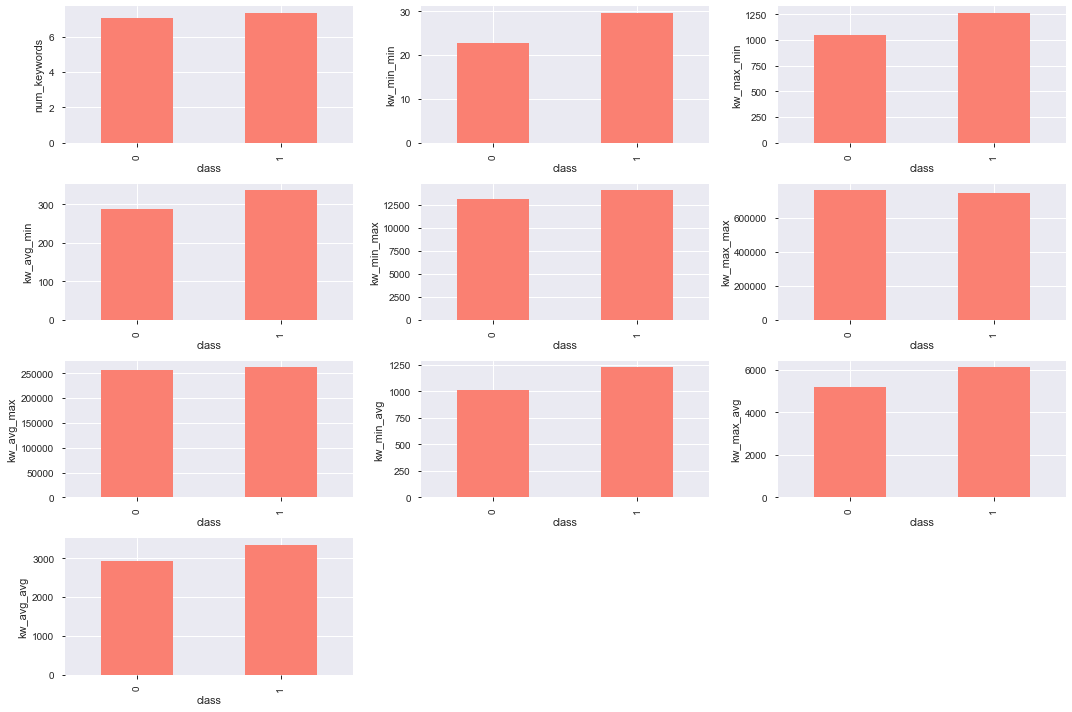

In [85]:
keywords = ['num_keywords','kw_min_min','kw_max_min','kw_avg_min','kw_min_max','kw_max_max','kw_avg_max','kw_min_avg','kw_max_avg','kw_avg_avg']
cnt=1
plt.figure(figsize=(15,10))
for i in keywords:
    plt.subplot(4,3,cnt)
    cnt+=1
    df.groupby('class')[i].mean().plot.bar(color='salmon')
    plt.ylabel(i)
plt.tight_layout()
plt.show()

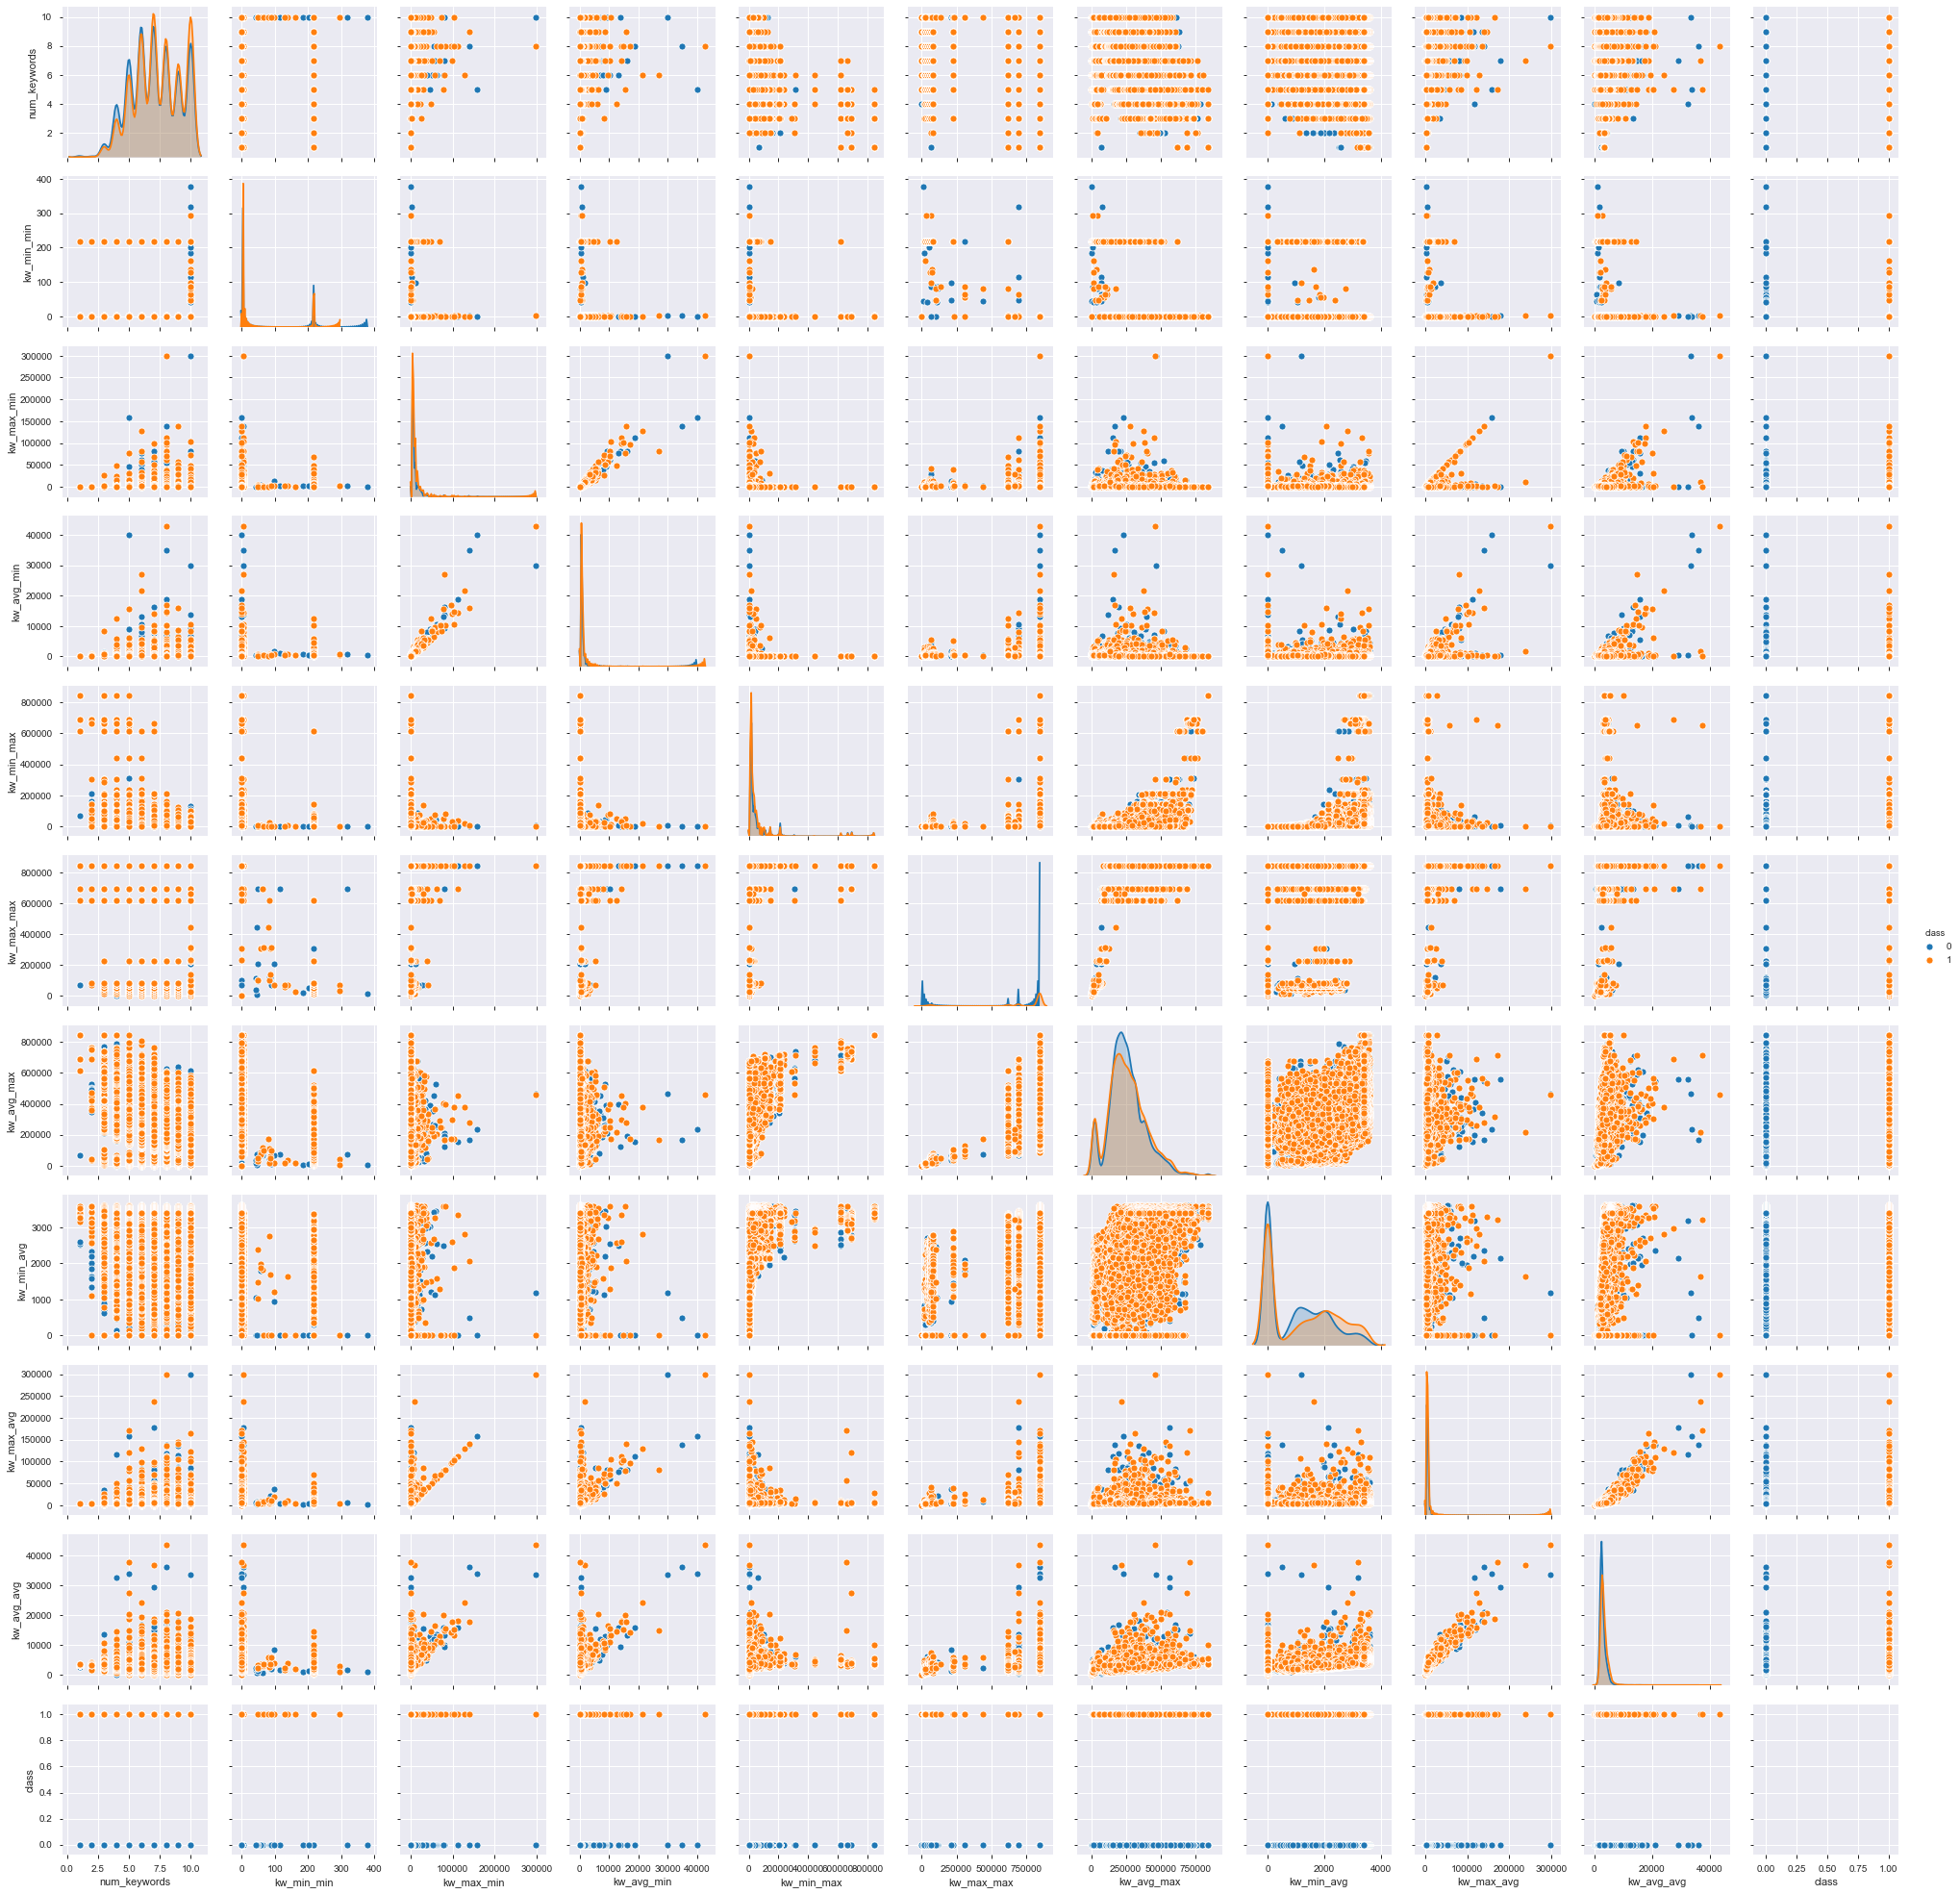

In [99]:
sns.pairplot(df,vars=df[keywords+['class']],diag_kind='kde',hue='class')
plt.show()

## Self Referencing links(#no of shares of articles mentioned in article)
<ol>
    <li>self_reference_min_shares: Min. shares of referenced articles in Mashable 
    <li>self_reference_max_shares: Max. shares of referenced articles in Mashable
    <li>self_reference_avg_sharess: Avg. shares of referenced articles in Mashable
<ol>

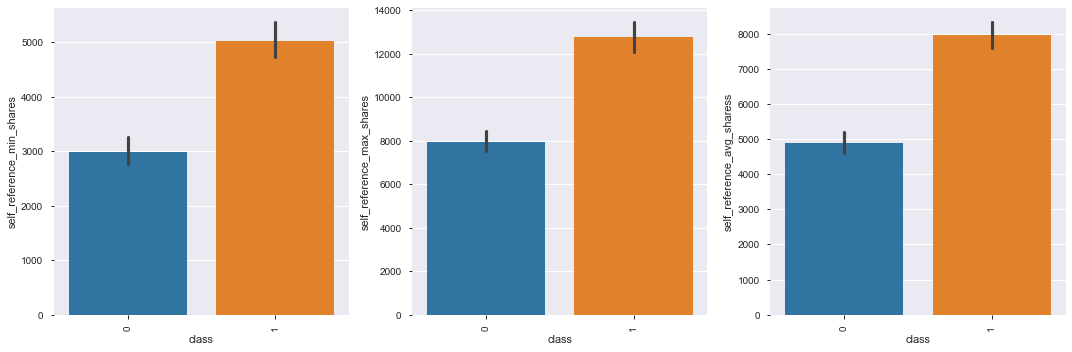

In [91]:
self_href = ['self_reference_min_shares','self_reference_max_shares','self_reference_avg_sharess']
cnt=1
plt.figure(figsize=(15,5))
for i in self_href:
    plt.subplot(1,3,cnt)
    cnt+=1
    sns.barplot(df['class'],df[i])
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
## more is the mean of shares of self referencing links, more are the chances that article will be popular
#if self referencing links are popular then article also most probably will be popular


## NLP Features
<ol>
<li>LDA_00: Closeness to LDA topic 0
<li>LDA_01: Closeness to LDA topic 1
<li>LDA_02: Closeness to LDA topic 2
<li>LDA_03: Closeness to LDA topic 3
<li>LDA_04: Closeness to LDA topic 4
<li>title_subjectivity: Title subjectivity
<li>title_sentiment_polarity: Title polarity
<li>abs_title_subjectivity: Absolute subjectivity level
<li>abs_title_sentiment_polarity: Absolute polarity level
<li>global_subjectivity: Text subjectivity
<li>global_sentiment_polarity: Text sentiment polarity
<li>global_rate_positive_words: Rate of positive words in the content
<li>global_rate_negative_words: Rate of negative words in the content
<li>avg_positive_polarity: Avg. polarity of positive words
<li>min_positive_polarity: Min. polarity of positive words
<li>max_positive_polarity: Max. polarity of positive words
<li>avg_negative_polarity: Avg. polarity of negative words
<li>min_negative_polarity: Min. polarity of negative words
<li>max_negative_polarity: Max. polarity of negative words
</ol>

### Closeness to LDA topic

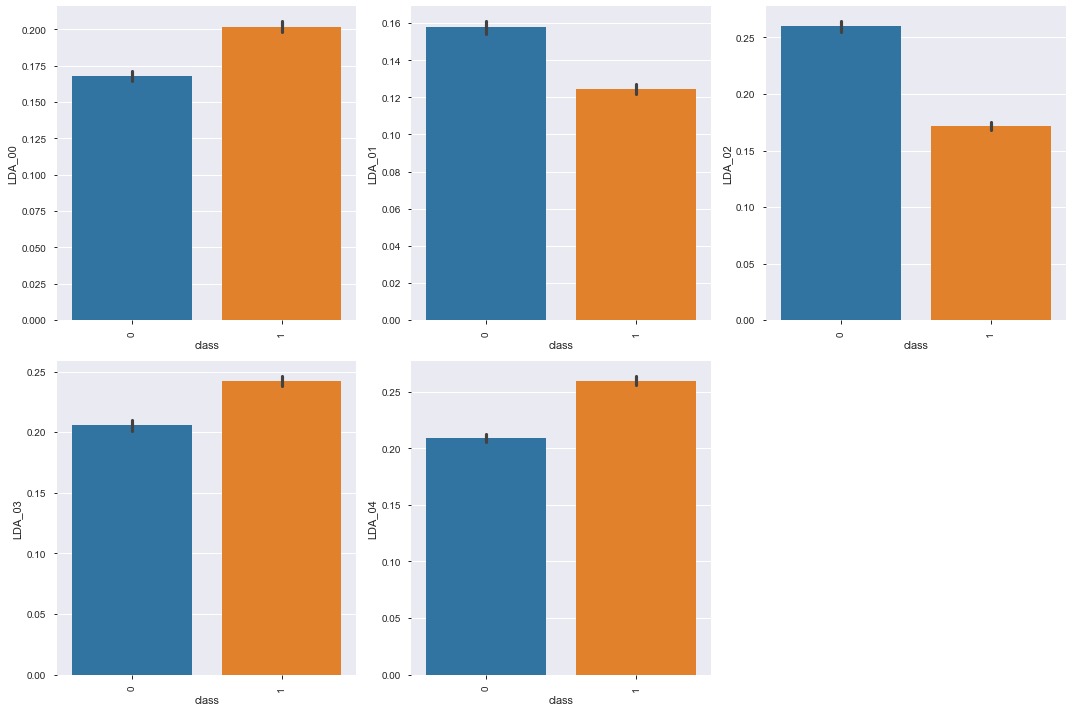

In [92]:
lda=['LDA_00','LDA_01','LDA_02','LDA_03','LDA_04']
cnt=1
plt.figure(figsize=(15,10))
for i in lda:
    plt.subplot(2,3,cnt)
    cnt+=1
    sns.barplot(df['class'],df[i])
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

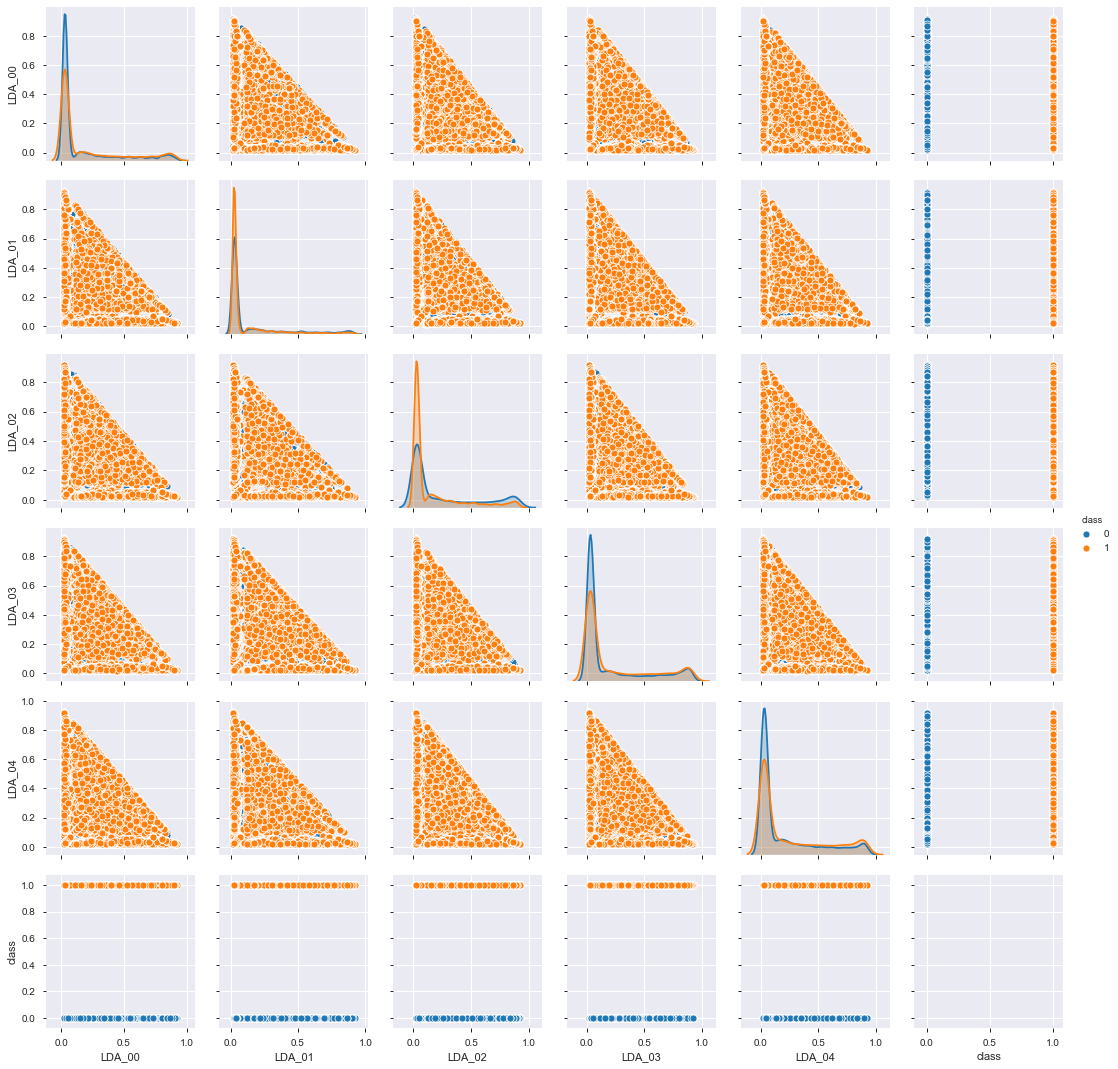

In [97]:
sns.pairplot(df,vars=df[lda+['class']],diag_kind='kde',hue='class')
plt.show()

### Title related

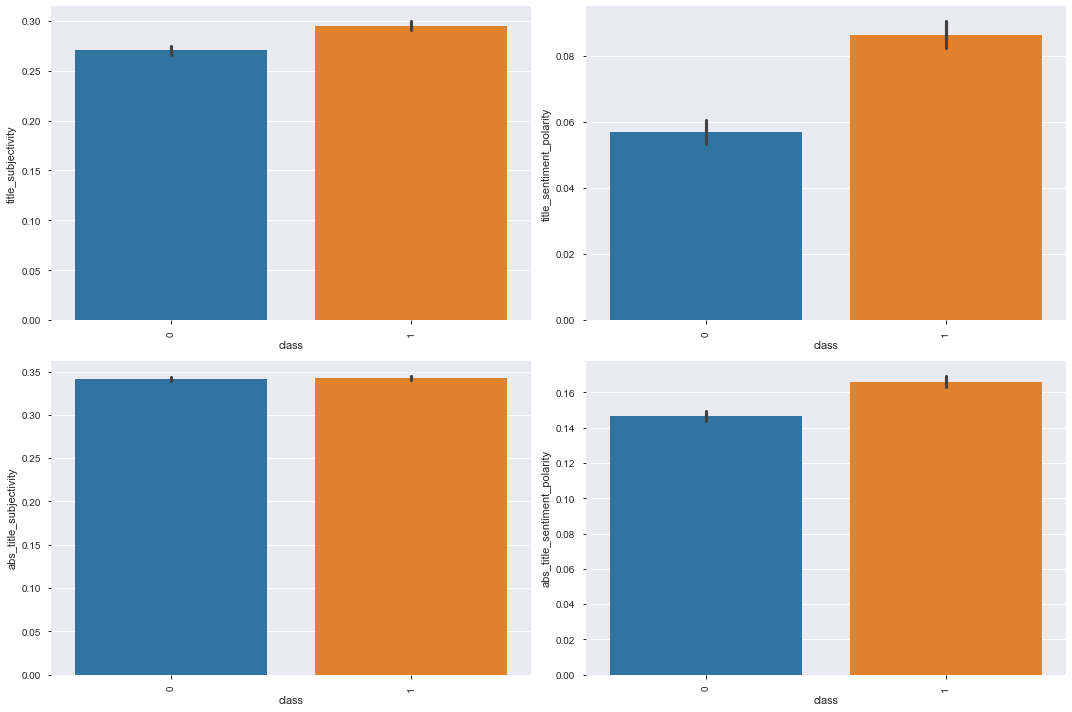

In [101]:
title=['title_subjectivity','title_sentiment_polarity','abs_title_subjectivity','abs_title_sentiment_polarity']
cnt=1
plt.figure(figsize=(15,10))
for i in title:
    plt.subplot(2,2,cnt)
    cnt+=1
    sns.barplot(df['class'],df[i])
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
#More the title_sentiment_polarity , more are the chances its a popular article

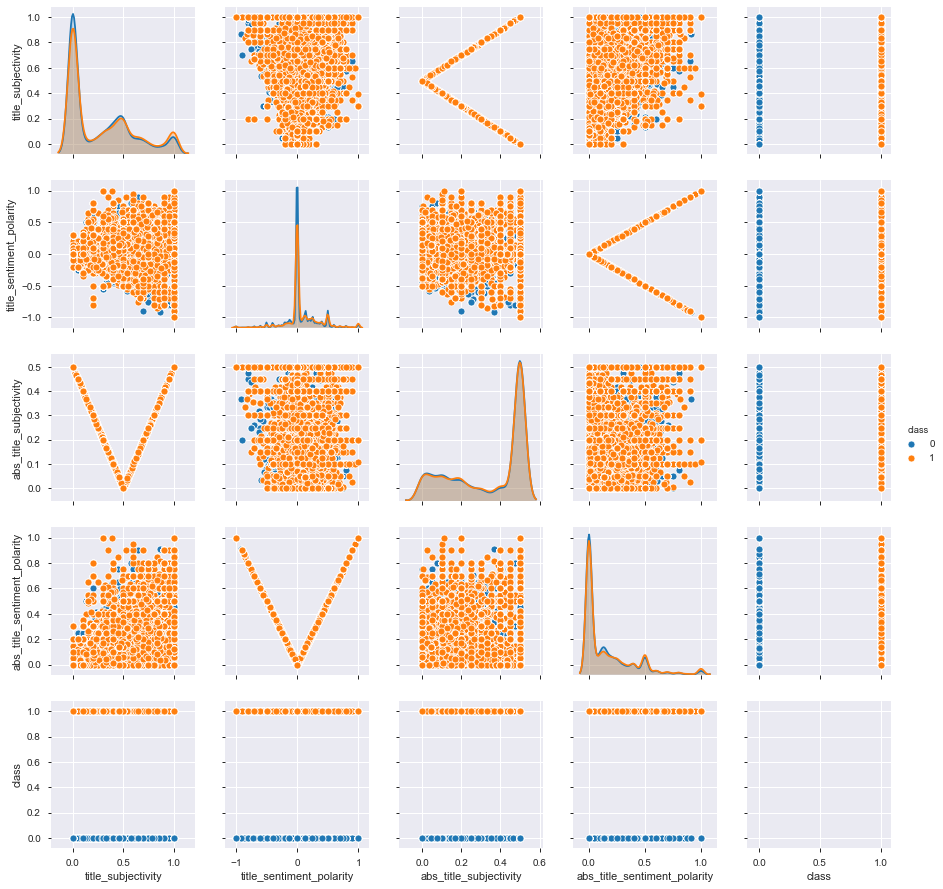

In [102]:
sns.pairplot(df,vars=df[title+['class']],diag_kind='kde',hue='class')
plt.show()

In [105]:
df[['title_sentiment_polarity','abs_title_sentiment_polarity']].corr()

title_sentiment_polarity  \
title_sentiment_polarity                      1.000000   
abs_title_sentiment_polarity                  0.410203   

                              abs_title_sentiment_polarity  
title_sentiment_polarity                          0.410203  
abs_title_sentiment_polarity                      1.000000

## Polarity
<li>global_subjectivity: Text subjectivity
<li>global_sentiment_polarity: Text sentiment polarity
<li>global_rate_positive_words: Rate of positive words in the content
<li>global_rate_negative_words: Rate of negative words in the content
<li>rate_positive_words: Rate of positive words among non-neutral tokens
<li>rate_negative_words: Rate of negative words among non-neutral tokens
<li>avg_positive_polarity: Avg. polarity of positive words
<li>min_positive_polarity: Min. polarity of positive words
<li>max_positive_polarity: Max. polarity of positive words
<li>avg_negative_polarity: Avg. polarity of negative words
<li>min_negative_polarity: Min. polarity of negative words
<li>max_negative_polarity: Max. polarity of negative words

In [106]:
pol=['global_subjectivity','global_sentiment_polarity','global_rate_positive_words','global_rate_negative_words',
'avg_positive_polarity','min_positive_polarity','max_positive_polarity','avg_negative_polarity','min_negative_polarity',
'max_negative_polarity']

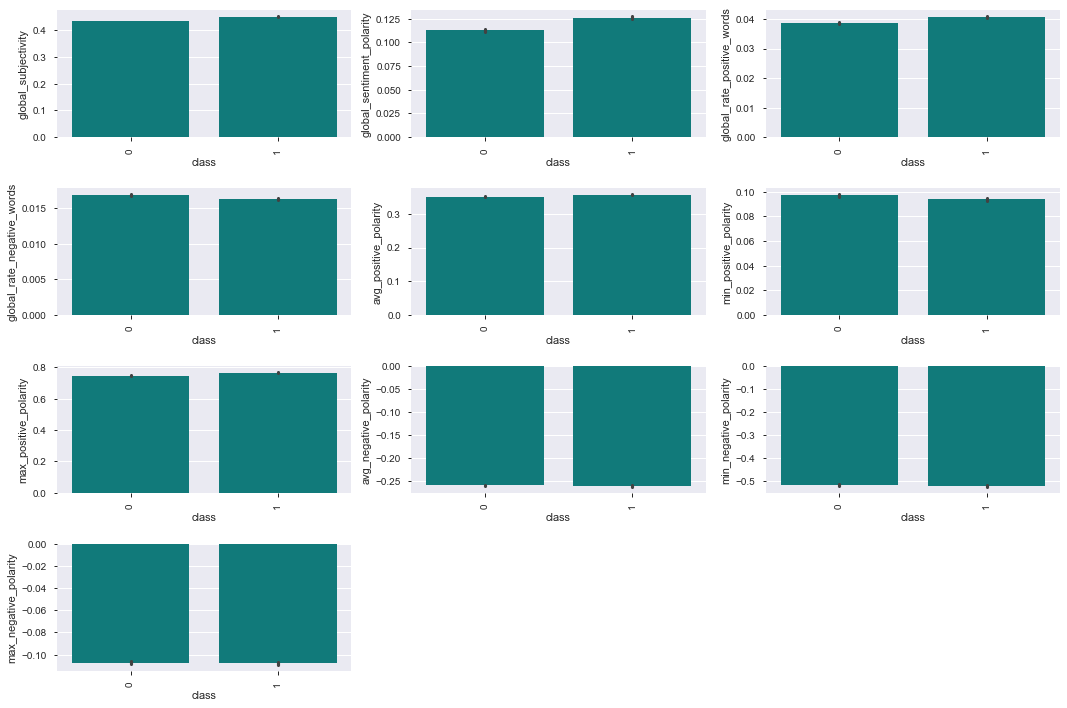

In [109]:
cnt=1
plt.figure(figsize=(15,10))
for i in pol:
    plt.subplot(4,3,cnt)
    cnt+=1
    sns.barplot(df['class'],df[i],color='darkcyan')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

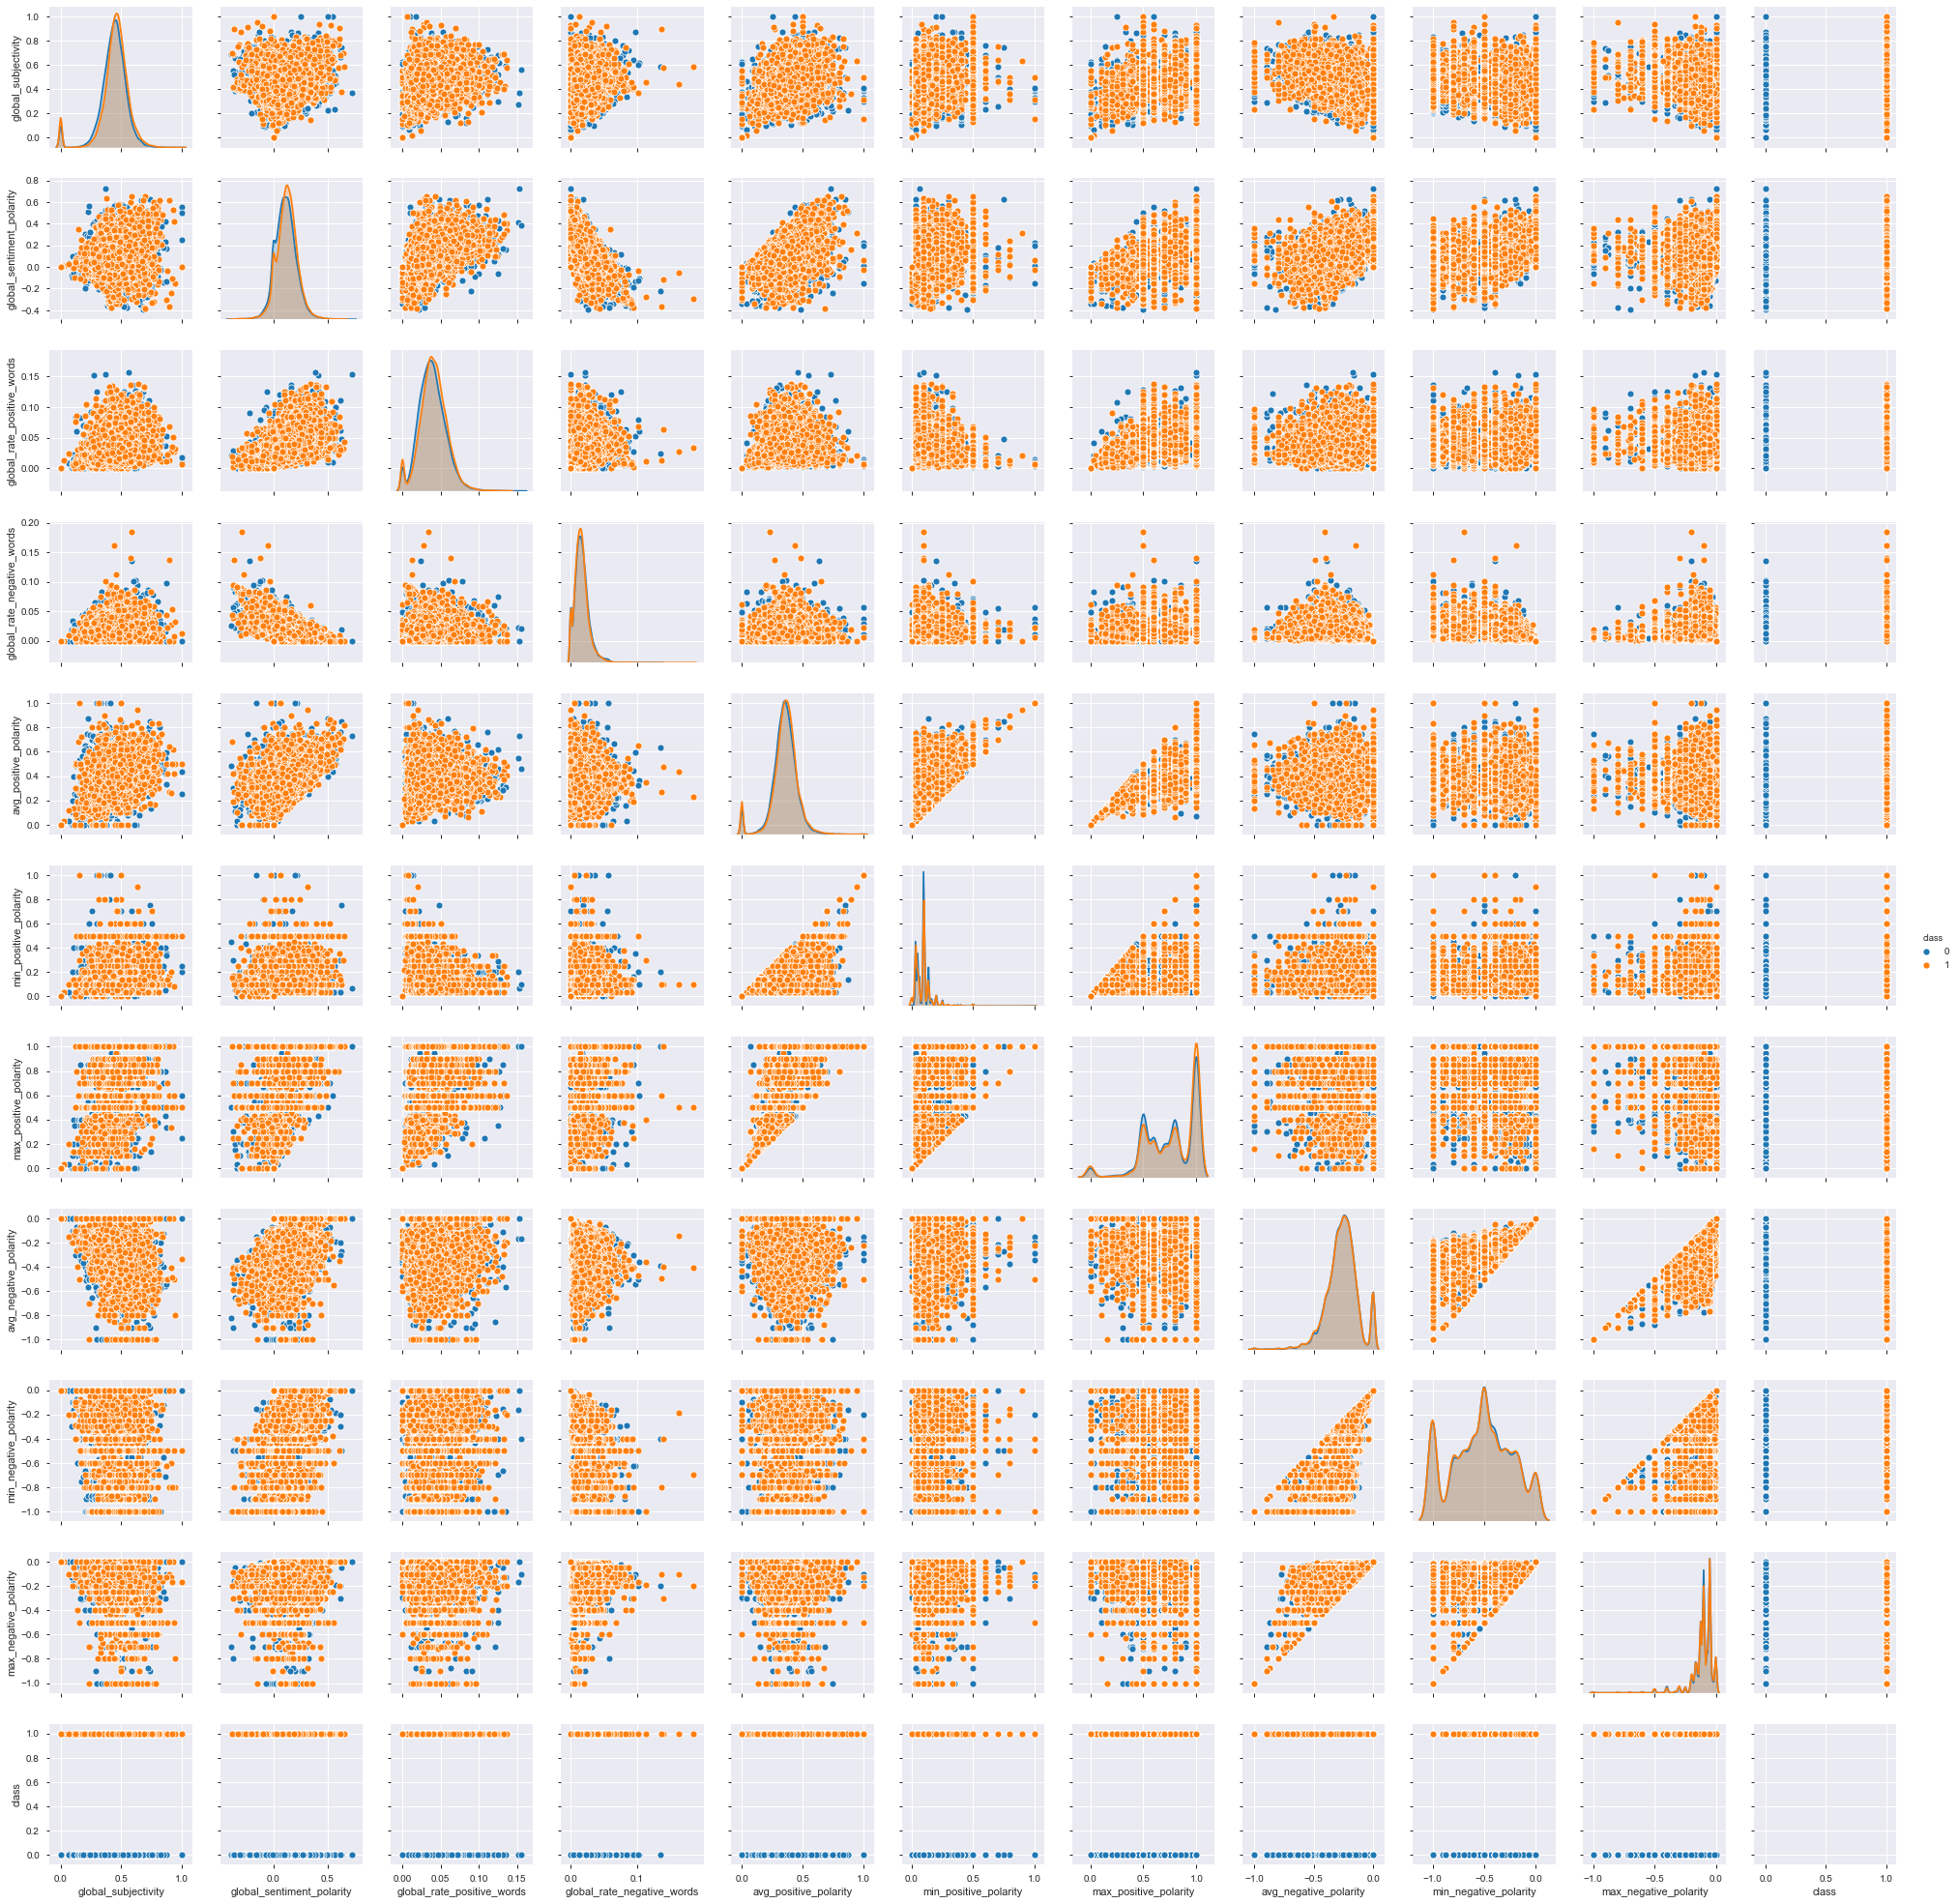

In [110]:
sns.pairplot(df,vars=df[title+['class']],diag_kind='kde',hue='class')
plt.show()

## Outlier Treatment

In [330]:
df_new=df.drop(columns=['url','timedelta','weekdays', 'data_channel'])

In [407]:
df_new.weekday_is_friday.value_counts()

0.0    33942
1.0     5701
Name: weekday_is_friday, dtype: int64

In [331]:
skew=[]
feature=[]
for i in df_new.columns:
    if (len(df[i].value_counts())>8) & (i!='shares'):
        feature.append(i)
        skew.append(df[i].skew()) 

In [332]:
df_skew=pd.DataFrame({'features':feature,'skewness_before':skew})

In [333]:
df_skew

features  skewness_before
0                 n_tokens_title         0.165278
1               n_tokens_content         2.945817
2                n_unique_tokens        -1.458581
3               n_non_stop_words        -5.531757
4       n_non_stop_unique_tokens        -2.406115
5                      num_hrefs         4.013445
6                 num_self_hrefs         5.173277
7                       num_imgs         3.947228
8                     num_videos         7.019447
9           average_token_length        -4.575946
10                  num_keywords        -0.147258
11                    kw_min_min         2.374903
12                    kw_max_min        35.327994
13                    kw_avg_min        31.305781
14                    kw_min_max        10.386263
15                    kw_max_max        -2.644936
16                    kw_avg_max         0.624345
17                    kw_min_avg         0.468042
18                    kw_max_avg        16.411515
19                    kw_avg_avg         5.760098
20     self_reference_min_shares        26.264047
21     self_reference_max_shares        13.870689
22    self_reference_avg_sharess        17.913869
23                        LDA_00         1.567428
24                        LDA_01         2.086686
25                        LDA_02         1.311661
26                        LDA_03         1.238681
27                        LDA_04         1.173096
28           global_subjectivity        -1.372325
29     global_sentiment_polarity         0.105416
30    global_rate_positive_words         0.323230
31    global_rate_negative_words         1.492006
32           rate_positive_words        -1.422888
33           rate_negative_words         0.407307
34         avg_positive_polarity        -0.724378
35         min_positive_polarity         3.040595
36         max_positive_polarity        -0.939589
37         avg_negative_polarity        -0.551781
38         min_negative_polarity        -0.073173
39         max_negative_polarity        -3.459821
40            title_subjectivity         0.816049
41      title_sentiment_polarity         0.396085
42        abs_title_subjectivity        -0.624206
43  abs_title_sentiment_polarity         1.704159

### Applying boxcox transformation to treat skewness

In [334]:
from scipy.stats import boxcox

In [335]:
for i in df_skew.features:
    if (min(df_new[i])<=0):
        df_new[i]=df_new[i]+np.abs(min(df_new[i]))+1

### Before boxcox transformation

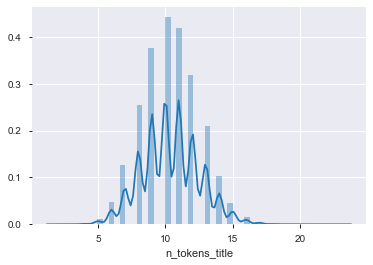

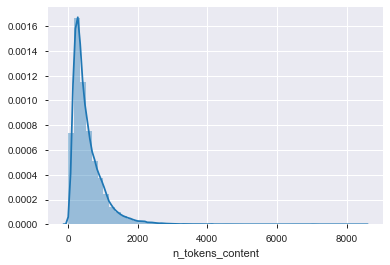

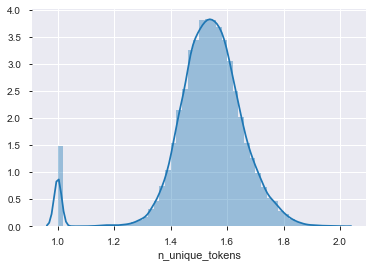

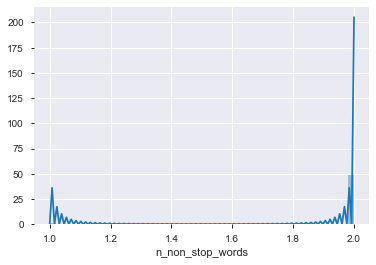

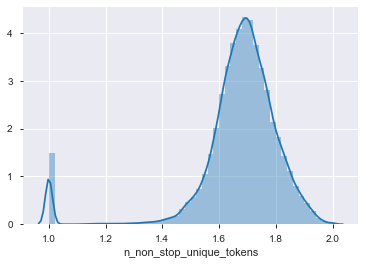

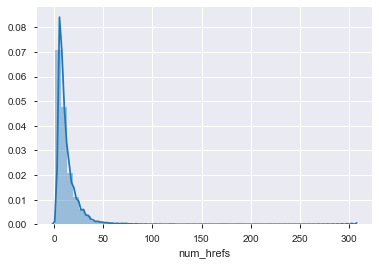

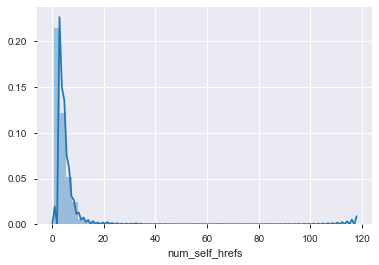

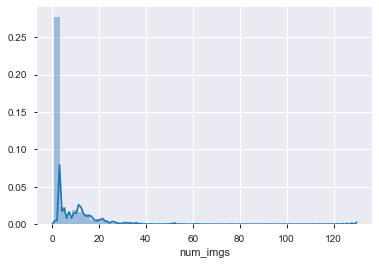

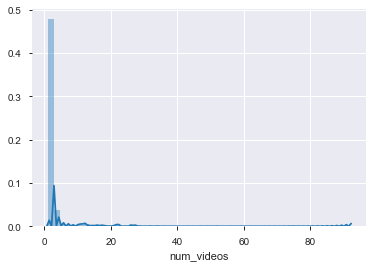

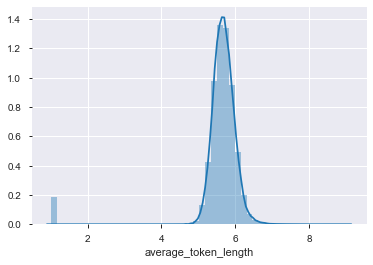

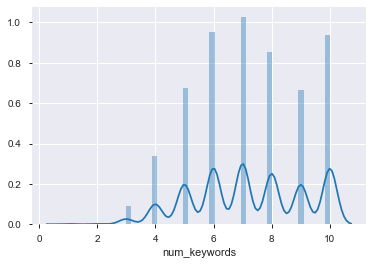

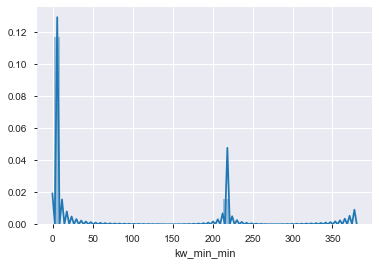

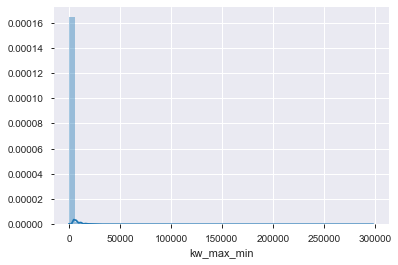

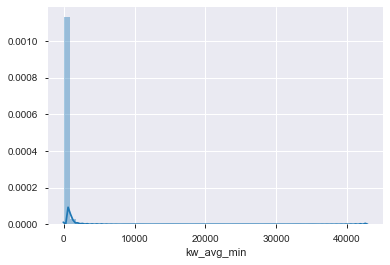

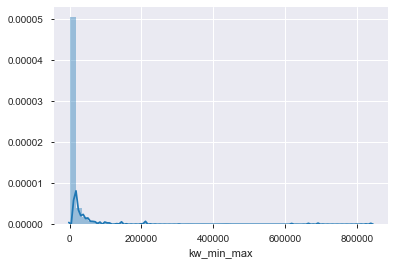

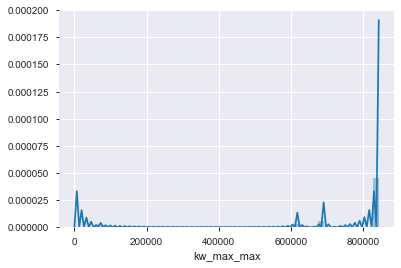

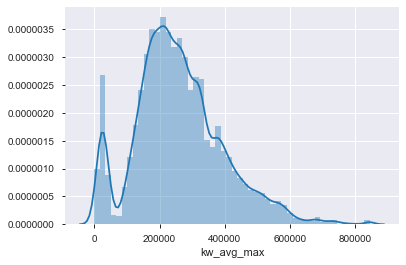

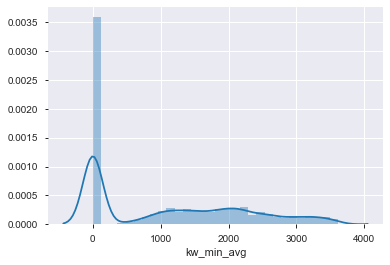

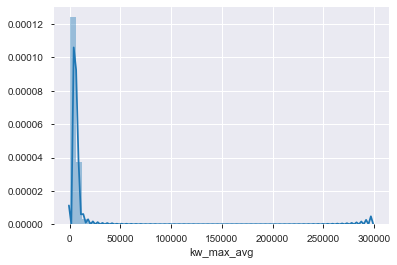

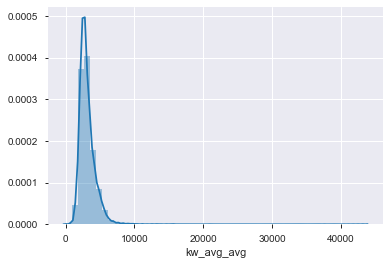

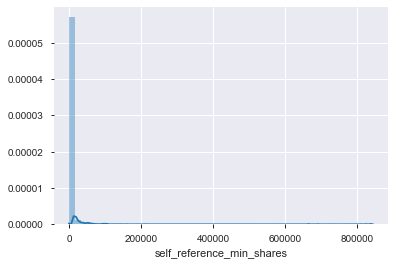

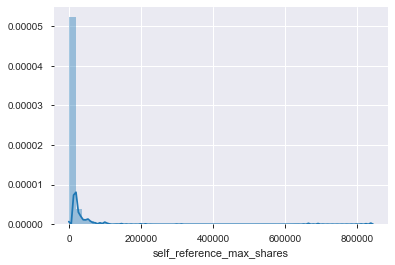

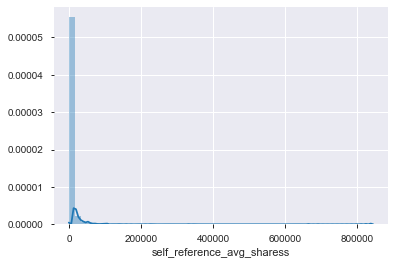

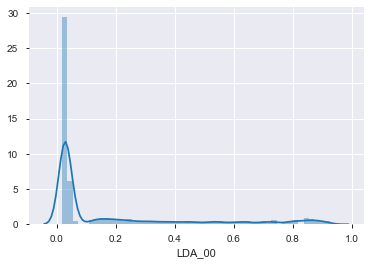

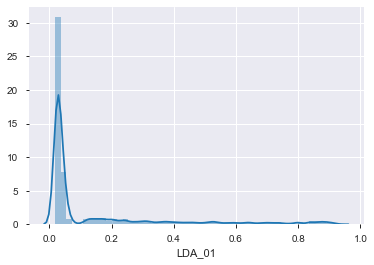

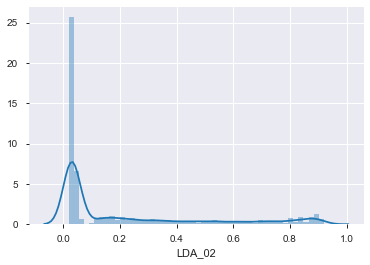

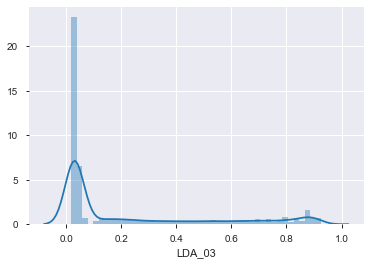

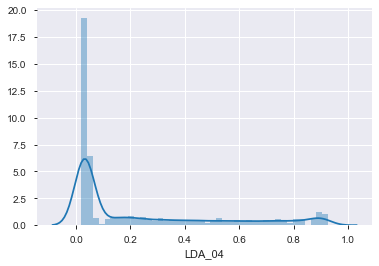

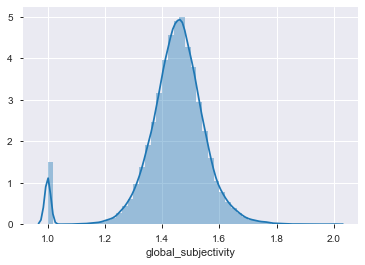

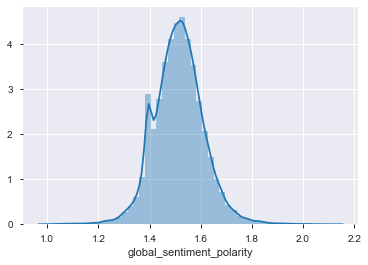

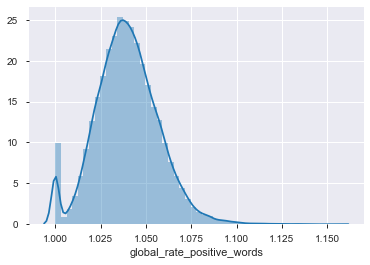

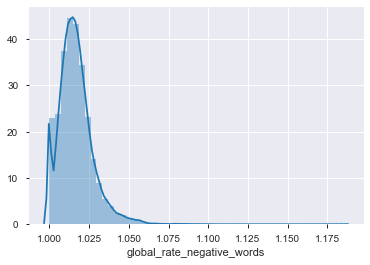

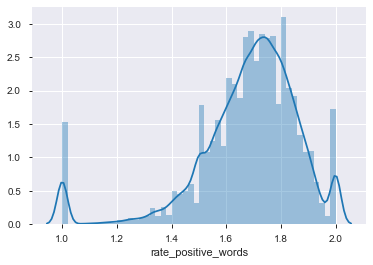

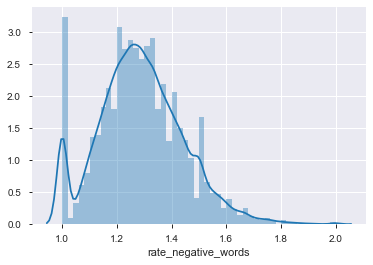

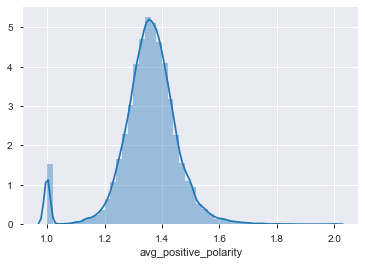

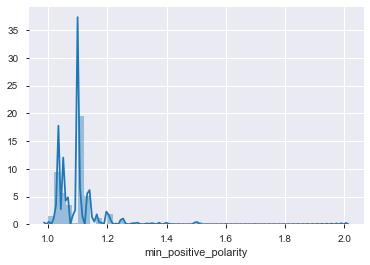

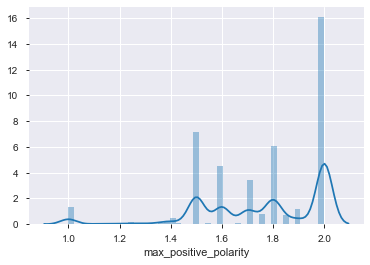

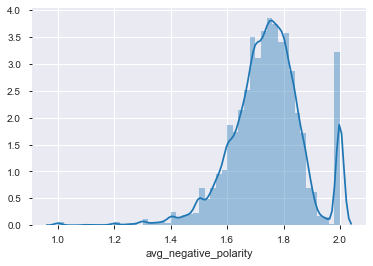

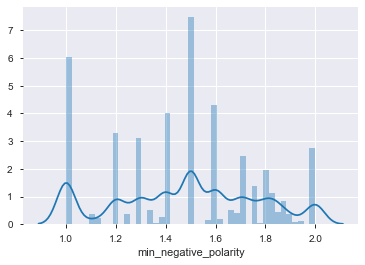

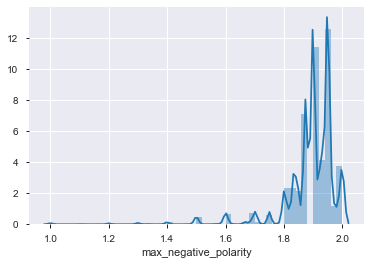

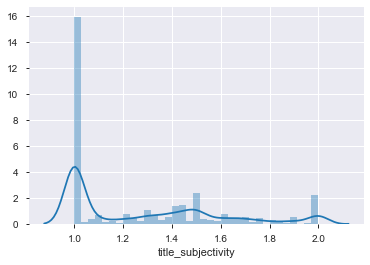

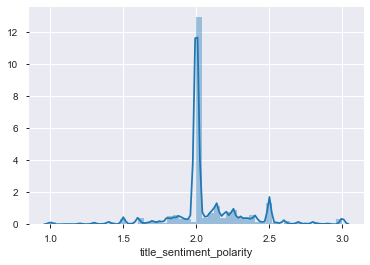

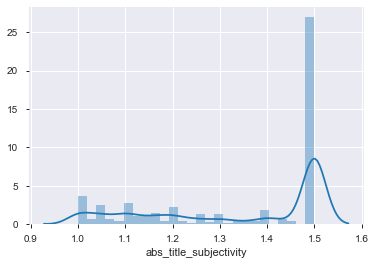

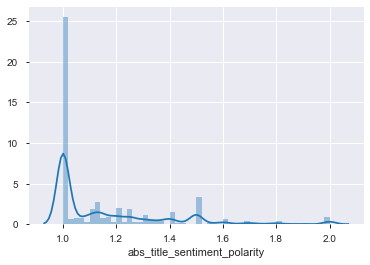

In [116]:
for i in df_skew.features:
    sns.distplot(df_new[i])
    plt.show()

In [336]:
for i in df_skew.features:
    df_new[i]=boxcox(df_new[i])[0]

### After boxcox

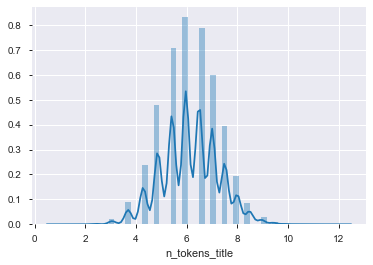

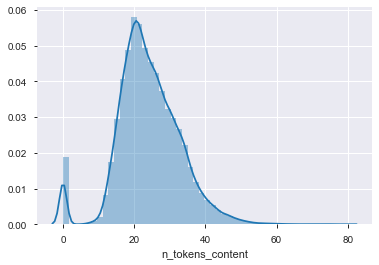

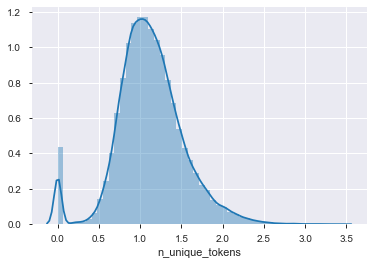

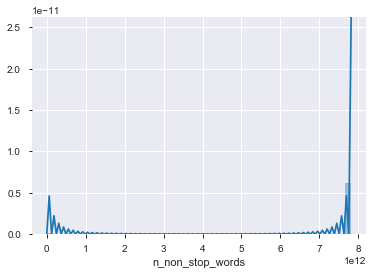

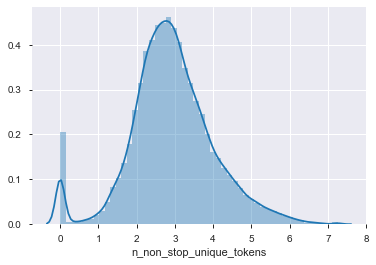

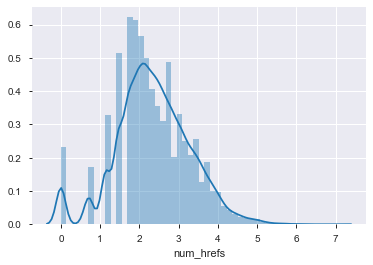

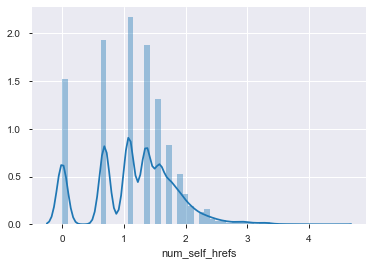

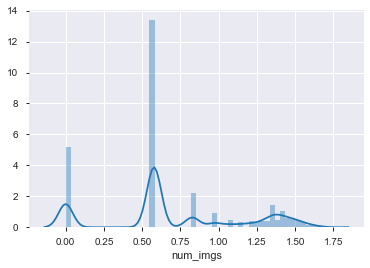

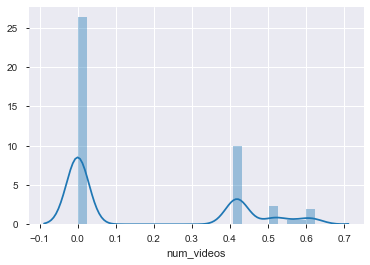

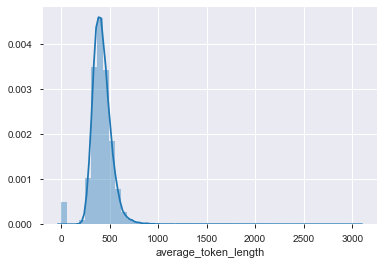

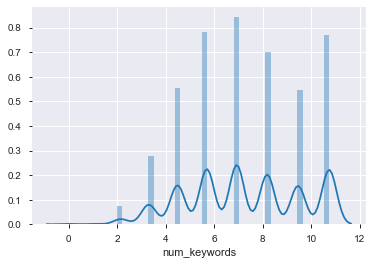

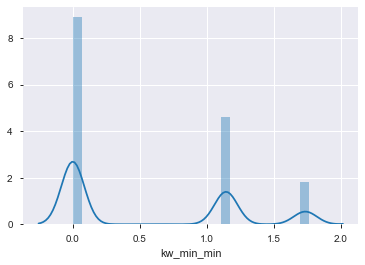

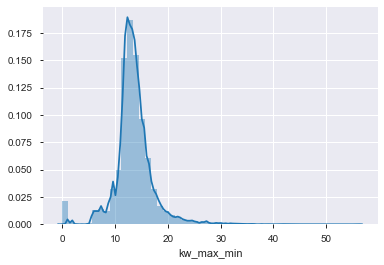

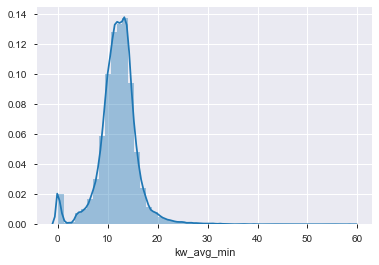

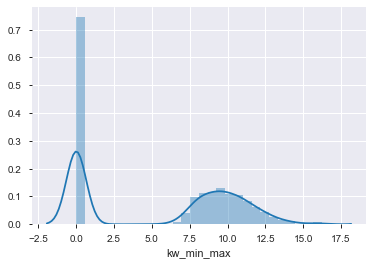

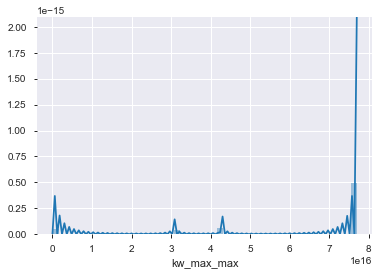

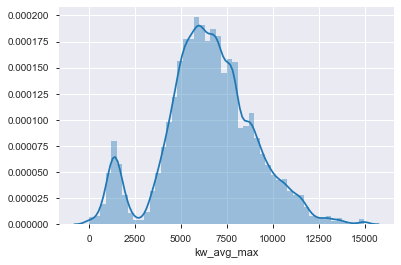

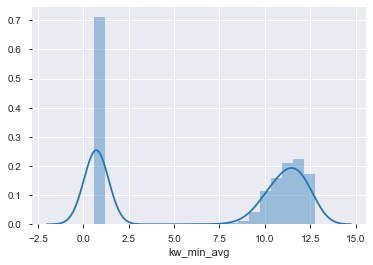

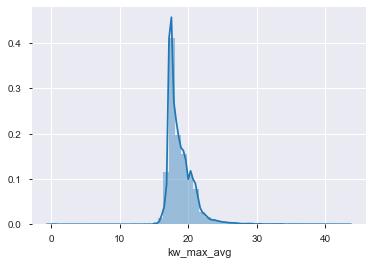

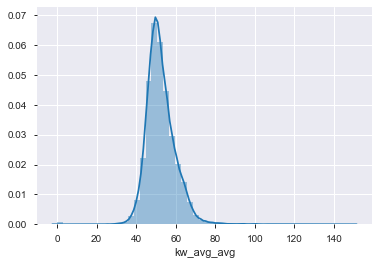

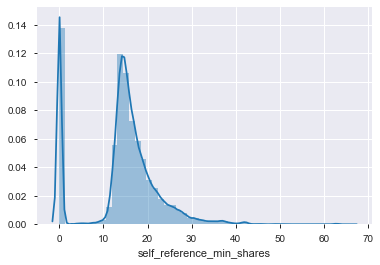

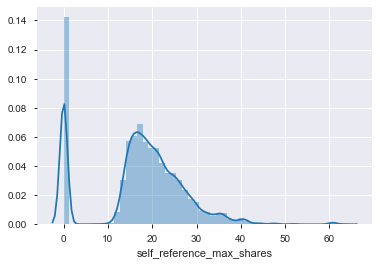

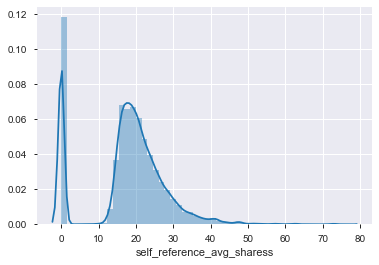

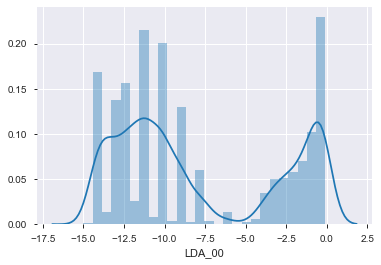

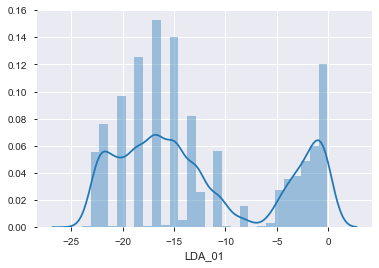

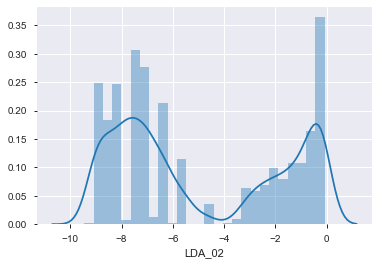

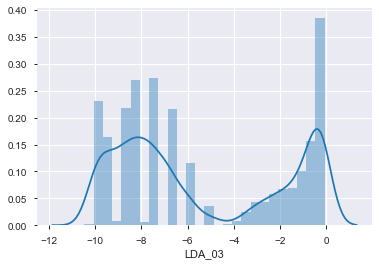

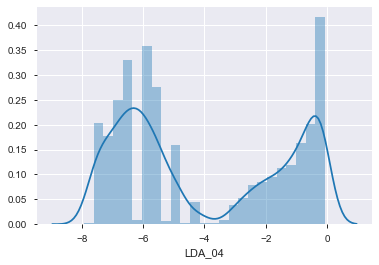

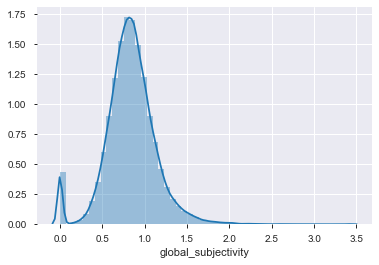

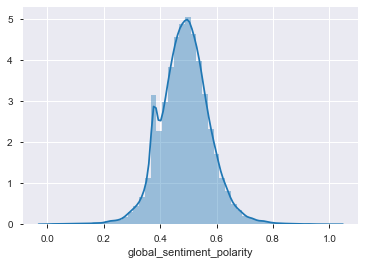

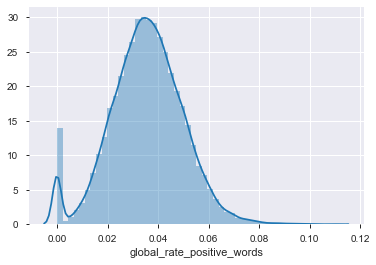

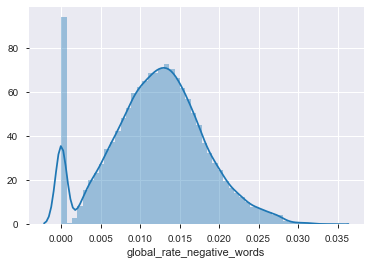

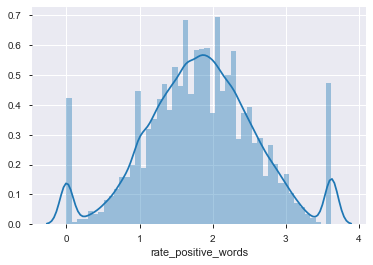

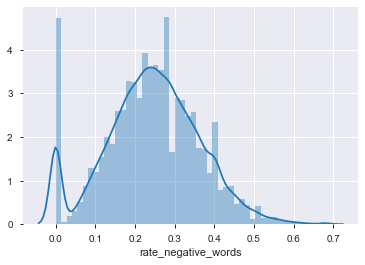

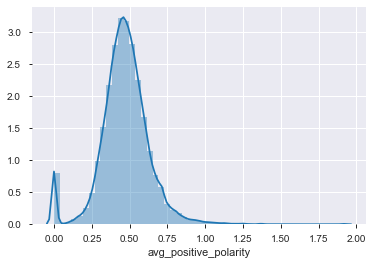

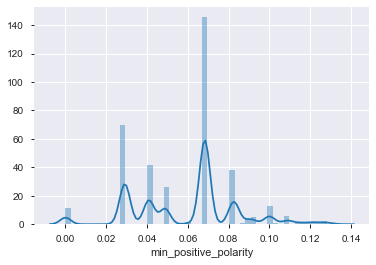

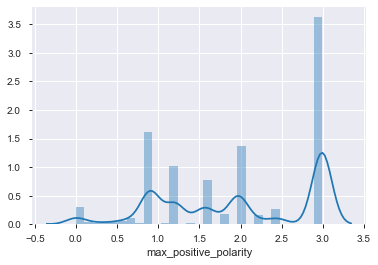

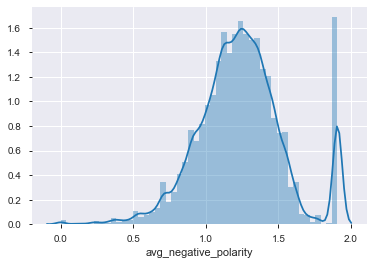

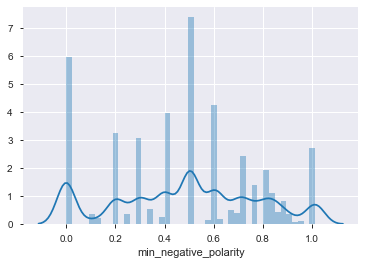

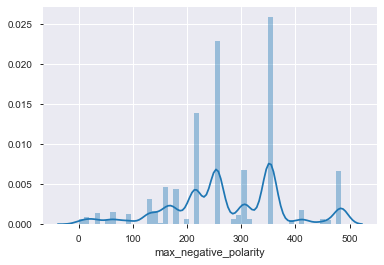

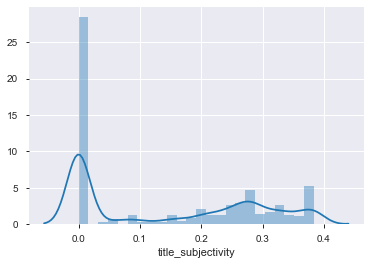

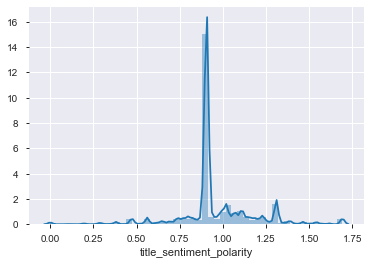

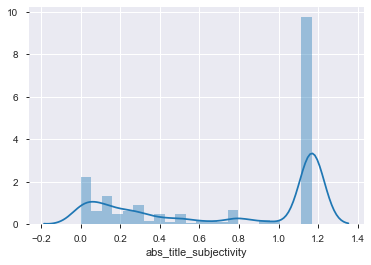

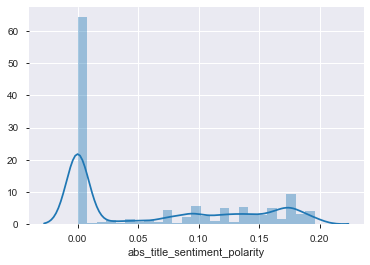

In [118]:
for i in df_skew.features:
    sns.distplot(df_new[i])
    plt.show()

In [337]:
skew_after=[]
for i in df_new.columns:
    if (len(df[i].value_counts())>8) & (i!='shares'):
        skew_after.append(df_new[i].skew()) 

In [338]:
df_skew['skewness_after']=skew_after

In [339]:
df_skew

features  skewness_before  skewness_after
0                 n_tokens_title         0.165278       -0.001479
1               n_tokens_content         2.945817        0.148320
2                n_unique_tokens        -1.458581        0.154094
3               n_non_stop_words        -5.531757       -5.531757
4       n_non_stop_unique_tokens        -2.406115        0.090153
5                      num_hrefs         4.013445        0.009333
6                 num_self_hrefs         5.173277       -0.000940
7                       num_imgs         3.947228        0.180154
8                     num_videos         7.019447        0.671934
9           average_token_length        -4.575946        0.361297
10                  num_keywords        -0.147258       -0.088994
11                    kw_min_min         2.374903        0.547576
12                    kw_max_min        35.327994        0.468495
13                    kw_avg_min        31.305781        0.426021
14                    kw_min_max        10.386263       -0.064142
15                    kw_max_max        -2.644936       -1.762517
16                    kw_avg_max         0.624345       -0.054478
17                    kw_min_avg         0.468042       -0.223021
18                    kw_max_avg        16.411515        0.766528
19                    kw_avg_avg         5.760098        0.610982
20     self_reference_min_shares        26.264047       -0.029711
21     self_reference_max_shares        13.870689       -0.100724
22    self_reference_avg_sharess        17.913869       -0.090111
23                        LDA_00         1.567428        0.431634
24                        LDA_01         2.086686        0.481379
25                        LDA_02         1.311661        0.300653
26                        LDA_03         1.238681        0.342048
27                        LDA_04         1.173096        0.243742
28           global_subjectivity        -1.372325        0.227649
29     global_sentiment_polarity         0.105416        0.025518
30    global_rate_positive_words         0.323230       -0.012868
31    global_rate_negative_words         1.492006        0.001887
32           rate_positive_words        -1.422888       -0.010640
33           rate_negative_words         0.407307       -0.000068
34         avg_positive_polarity        -0.724378        0.210270
35         min_positive_polarity         3.040595        0.013354
36         max_positive_polarity        -0.939589       -0.227606
37         avg_negative_polarity        -0.551781        0.069481
38         min_negative_polarity        -0.073173       -0.061590
39         max_negative_polarity        -3.459821       -0.114785
40            title_subjectivity         0.816049        0.253249
41      title_sentiment_polarity         0.396085        0.119313
42        abs_title_subjectivity        -0.624206       -0.414083
43  abs_title_sentiment_polarity         1.704159        0.496224

## Splitting dependent and independent variable

In [340]:
X=df_new.drop(columns=['shares','class'])
Y=df_new['class']

## Checking Mulitcollinearity

In [341]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif=[[variance_inflation_factor(X.values,i) for i in range(X.shape[1])],[i for i in X.columns]]

In [342]:
df_vif=pd.DataFrame({'features':vif[1],'vif':vif[0]})

In [343]:
df_vif[df_vif.vif>=10]

Empty DataFrame
Columns: [features, vif]
Index: []

In [344]:
#No multicollinearity found as all vif values less than 10

## Train Test split

In [345]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=.3,random_state=1)

In [346]:
X_train.shape

(27750, 58)

In [347]:
Y_train.shape

(27750,)

## Logistic Regression

In [348]:
lr=LogisticRegression(fit_intercept=True)
lr.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [349]:
from sklearn.model_selection import cross_val_score

In [350]:
s=cross_val_score(lr,X_train,Y_train,scoring='roc_auc',cv=10)

In [351]:
bias=1-s

In [352]:
bias.mean()#high bias error

0.4756890223757094

In [353]:
np.var(s)#low variance error

0.00015807679418880293

In [354]:
y_train_pred=lr.predict(X_train)#gives classified values in 0 and 1 
y_train_prob=lr.predict_proba(X_train)[:,1]# gives probabilities
    
y_test_pred=lr.predict(X_test)
y_test_prob=lr.predict_proba(X_test)[:,1]
    
print(f'accuracy score of train {accuracy_score(Y_train,y_train_pred)}')
print(f'accuracy score of test {accuracy_score(Y_test,y_test_pred)}')
    
print(f'AUC  of train {roc_auc_score(Y_train,y_train_prob)}')
print(f'AUC of test {roc_auc_score(Y_test,y_test_prob)}')

accuracy score of train 0.5096216216216216
accuracy score of test 0.4994534600184983
AUC  of train 0.5253846312213626
AUC of test 0.519706584858609


In [355]:
confusion_matrix(Y_test,y_test_pred)

array([[5940,    0],
       [5953,    0]], dtype=int64)

In [252]:
# none of the popular cases have been predicted correctly by logistic regression

In [244]:
report_lr=classification_report(Y_test,y_test_pred,output_dict=True)
print(classification_report(Y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      5980
           1       0.00      0.00      0.00      5914

    accuracy                           0.50     11894
   macro avg       0.25      0.50      0.33     11894
weighted avg       0.25      0.50      0.34     11894



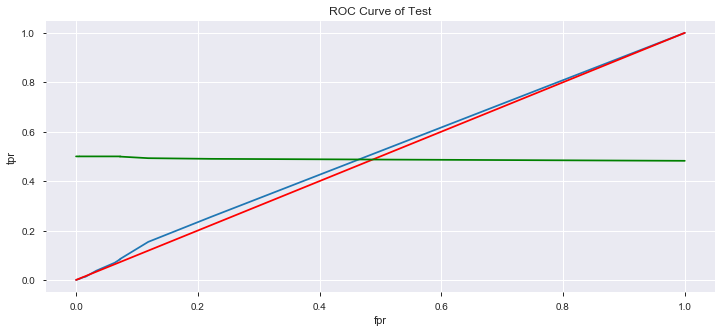

In [255]:
plt.figure(figsize=(12,5))
fpr,tpr,thresholds=roc_curve(Y_test,y_test_prob)
    
thresholds[0]=thresholds[0]-1# first threshold value  is always greater than 1
    #print(f'threshold value are {thresholds}')
df_metric=pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':thresholds})
plt.title('ROC Curve of Test')
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,color='r')
plt.plot(fpr,thresholds,color='g')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

In [ ]:
# this is the worst model as auc is coming out to be .5

In [247]:
df_analysis.loc[2]=['Logistic Regression Base',roc_auc_score(Y_test,y_test_prob),accuracy_score(Y_test,y_test_pred),report_lr['1']['precision'],report_lr['1']['recall']]

In [98]:
from scipy.stats import randint as sp_randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,accuracy_score

## Decision Tree Classifier

In [173]:
dtree=DecisionTreeClassifier(random_state=1)
params={'max_depth':sp_randint(2,10),
       'min_samples_split':sp_randint(2,20),
       'min_samples_leaf':sp_randint(1,20),
       'criterion':['gini','entropy']}
rsearch=RandomizedSearchCV(dtree,param_distributions=params,cv=10,random_state=1,scoring='roc_auc')
rsearch.fit(X_train,Y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=1,
            

In [174]:
results=pd.DataFrame(rsearch.cv_results_)


In [175]:
results['var']=results.std_test_score.apply(lambda x:x*x)
results['bias_err']=results.mean_test_score.apply(lambda x:1-x)
results['avg_error']=results[['bias_err','var']].agg('mean',axis=1)
results[results.avg_error==min(results.avg_error)]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7       0.675602      0.042927         0.001907          0.0017   

  param_criterion param_max_depth param_min_samples_leaf  \
7         entropy               8                      1   

  param_min_samples_split                                             params  \
7                      15  {'criterion': 'entropy', 'max_depth': 8, 'min_...   

   split0_test_score  ...  split6_test_score  split7_test_score  \
7           0.678993  ...           0.685637           0.655735   

   split8_test_score  split9_test_score  mean_test_score  std_test_score  \
7           0.689563           0.696705         0.678271        0.011959   

   rank_test_score       var  bias_err  avg_error  
7                1  0.000143  0.321729   0.160936  

[1 rows x 25 columns]

In [176]:
rsearch.best_params_#same results taking var error into account

{'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 15}

In [177]:
rsearch.best_score_

0.6782707644671777

In [178]:
dtree=DecisionTreeClassifier(**rsearch.best_params_)
dtree.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [179]:
y_train_pred=dtree.predict(X_train)
y_train_prob=dtree.predict_proba(X_train)[:,1]
print(f'Accuracy of train {accuracy_score(Y_train,y_train_pred)}')
print(f'AUC of train {roc_auc_score(Y_train,y_train_prob)}')
print(f'confusion matrix {confusion_matrix(Y_train,y_train_pred)}')
print('\n')
y_test_pred=dtree.predict(X_test)
y_test_prob=dtree.predict_proba(X_test)[:,1]
print(f'confusion matrix {confusion_matrix(Y_test,y_test_pred)}')
print(f'Accuracy of test {accuracy_score(Y_test,y_test_pred)}')
print(f'AUC of test {roc_auc_score(Y_test,y_test_prob)}')


Accuracy of train 0.6717117117117117
AUC of train 0.7425148688511752
confusion matrix [[9598 4504]
 [4606 9042]]


confusion matrix [[3874 2106]
 [2236 3678]]
Accuracy of test 0.6349419875567514
AUC of test 0.6816145408604717


In [180]:
report=classification_report(Y_test,y_test_pred,output_dict=True)

In [181]:
print(classification_report(Y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64      5980
           1       0.64      0.62      0.63      5914

    accuracy                           0.63     11894
   macro avg       0.63      0.63      0.63     11894
weighted avg       0.63      0.63      0.63     11894



In [182]:
df_analysis=pd.DataFrame({'Model':[],'AUC_Score':[],'Accuracy':[],'Precision':[],'Recall':[]})

In [183]:
df_analysis.loc[0]=(['Decison Tree Base',roc_auc_score(Y_test,y_test_prob),accuracy_score(Y_test,y_test_pred),report['1']['precision'],report['1']['recall']])

## Random Forest Classifier

In [185]:
from sklearn.ensemble import RandomForestClassifier

In [147]:
from scipy.stats import randint as sp_randint
rf=RandomForestClassifier(random_state=1)
params={'n_estimators':sp_randint(50,1000),
       'max_depth':sp_randint(2,10),
       'min_samples_leaf':sp_randint(1,20),
       'min_samples_split':sp_randint(2,20),
       'criterion':['gini','entropy'],
        'max_features':sp_randint(2,31)
       }
rsearch1=RandomizedSearchCV(estimator=rf,param_distributions=params,cv=10,random_state=1,scoring='roc_auc')
rsearch1.fit(X_train,Y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [148]:
results1=pd.DataFrame(rsearch1.cv_results_)


results1['var']=results1.std_test_score.apply(lambda x:x*x)
results1['bias_err']=results1.mean_test_score.apply(lambda x:1-x)
results1['avg_error']=results1[['bias_err','var']].agg('mean',axis=1)
results1[results1.avg_error==min(results1.avg_error)]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
6      70.424161       0.85022         0.120009        0.003952   

  param_criterion param_max_depth param_max_features param_min_samples_leaf  \
6         entropy               9                 24                      2   

  param_min_samples_split param_n_estimators  ... split6_test_score  \
6                       2                366  ...          0.725757   

   split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
6           0.695308           0.730396           0.725651         0.719381   

   std_test_score  rank_test_score       var  bias_err  avg_error  
6        0.010715                1  0.000115  0.280619   0.140367  

[1 rows x 27 columns]

In [149]:
rsearch1.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 24,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 366}

In [150]:
rsearch1.best_score_

0.7193808213539481

In [151]:
rf=RandomForestClassifier(**rsearch1.best_params_)
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features=24,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=366,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [152]:
y_train_pred=rf.predict(X_train)
y_train_prob=rf.predict_proba(X_train)[:,1]
print(f'Accuracy of train {accuracy_score(Y_train,y_train_pred)}')
print(f'AUC of train {roc_auc_score(Y_train,y_train_prob)}')
print(f'confusion matrix {confusion_matrix(Y_train,y_train_pred)}')
print('\n')
y_test_pred=rf.predict(X_test)
y_test_prob=rf.predict_proba(X_test)[:,1]
print(f'confusion matrix {confusion_matrix(Y_test,y_test_pred)}')
print(f'Accuracy of test {accuracy_score(Y_test,y_test_pred)}')
print(f'AUC of test {roc_auc_score(Y_test,y_test_prob)}')


Accuracy of train 0.7417297297297297
AUC of train 0.8225446267131299
confusion matrix [[10576  3526]
 [ 3641 10007]]


confusion matrix [[4059 1921]
 [2008 3906]]
Accuracy of test 0.6696653775012611
AUC of test 0.7299249386128714


In [160]:
report2=classification_report(Y_test,y_test_pred,output_dict=True)
print(classification_report(Y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.67      0.68      0.67      5980
           1       0.67      0.66      0.67      5914

    accuracy                           0.67     11894
   macro avg       0.67      0.67      0.67     11894
weighted avg       0.67      0.67      0.67     11894



In [191]:
df_analysis.loc[1]=(['Random Forest Base',0.729924,report2['accuracy'],report2['1']['precision'],report2['1']['recall']])

In [192]:
df_analysis

Model  AUC_Score  Accuracy  Precision    Recall
0   Decison Tree Base   0.681615  0.634942   0.635892  0.621914
1  Random Forest Base   0.729924  0.669665   0.670328  0.660467

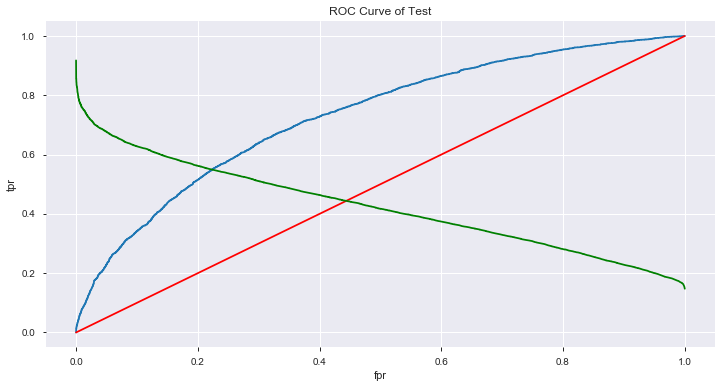

In [154]:
# to plot roc curve
plt.figure(figsize=(12,6))
fpr,tpr,thresholds=roc_curve(Y_test,y_test_prob)
    
thresholds[0]=thresholds[0]-1# first threshold value  is always greater than 1
    #print(f'threshold value are {thresholds}')
df_metric=pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':thresholds})
plt.title('ROC Curve of Test')
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,color='r')
plt.plot(fpr,thresholds,color='g')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

In [164]:
imp=pd.DataFrame(rf.feature_importances_,index=X.columns,columns=['importance'])
imp=imp.sort_values(by='importance',ascending=False)

Text(0.5, 1.0, 'Feature importance ')

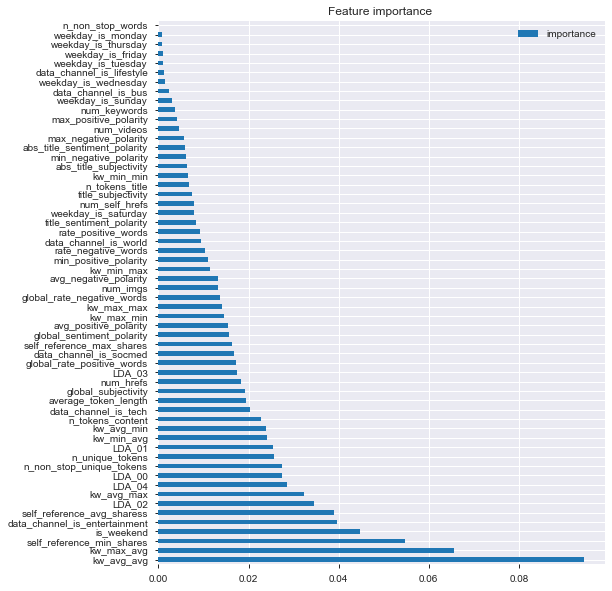

In [165]:

import matplotlib
matplotlib.rcParams['figure.figsize']=(8.0,10.0)
imp.plot(kind='Barh')
plt.title('Feature importance ')

## Base Models Comparison

In [274]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [275]:
df_analysis.style.apply(highlight_max)

## Feature Engineering

In [73]:
from sklearn.feature_selection import RFECV

In [87]:
#Initializing RFE model
rfe = RFECV(rf,cv=10,scoring='roc_auc')

In [88]:
#Transforming data using RFE
cols = list(X.columns)
X_rfe = rfe.fit_transform(X_train,Y_train)  



KeyboardInterrupt: 

In [77]:
rf.fit(X_rfe,Y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)


Index(['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'average_token_length',
       'num_keywords', 'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_saturday',
       'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02',
       'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'avg_negative_polarity', 'min_negative_polarity', 'title_subjectiv

In [78]:
len(selected_features_rfe)

47

In [85]:
rf.score(X_rfe,Y_train)

0.6714954954954955

In [86]:
rf.score(rfe.transform(X_test),Y_test)

0.6619303850681015

## Backward Elimination

In [359]:
import statsmodels.api as sm

In [360]:
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.Logit(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

Optimization terminated successfully.
         Current function value: 0.623686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623700
  

In [361]:
a=['n_tokens_content', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'num_keywords', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_max_avg', 'kw_avg_avg', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_saturday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_04', 'global_subjectivity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'min_positive_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity']

In [362]:
len(a)

39

## Boosting

In [195]:
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier


In [197]:
ada_rf=AdaBoostClassifier(base_estimator=rf,random_state=1)
params={'n_estimators':sp_randint(1,100),
       }
rsearch3=RandomizedSearchCV(estimator=ada_rf,param_distributions=params,cv=10,random_state=1,scoring='roc_auc')
rsearch3.fit(X_train,Y_train)

KeyboardInterrupt: 